<a href="https://colab.research.google.com/github/pascal-maker/machinelearning/blob/main/Hands_on_Logistic_RegressionPascalMusabyimana_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment logistic regression

Logistic regression is a popular classification technique due to its simplicity, interpretability and performance.

The goal of this assignment is to get insight into the following topics:
- Being able to train a logistic regression model.
- Performing hyperparameter tuning.
- Testing and evaluation of the trained model. Being able to assess the model by means of different classification metrics: accuracy, recall, precision, f1-score.
- Knowing how to deal with underfitting and overfitting.

It looks like your professor is using a slightly different approach for predicting the cultivar of a wine in this assignment. I'll break down the main differences and why they might be used:

Key Differences in the Prediction Approach
Feature Scaling:

In the notebook, the code first scales the data using StandardScaler():

python
Copy
Edit
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
This is necessary because logistic regression can be sensitive to the scale of the input features, especially when you have features like Proline (which can be in the thousands) and others like Hue (which are typically less than 1).

Direct Input without Full Training Set Context:

The professor's example for making a prediction uses:

python
Copy
Edit
wine = [[9, 2.05, 2.20, 17.3, 120, 2.60, 3.52, 0.30, 2.28, 7.80, 0.77, 2.90, 862]]
wine = scaler.transform(wine)
logRegModel.predict_proba(wine)
Here, they are assuming that the input wine data is already scaled using the same scaler that was fitted to the training data. This is important because the model's coefficients were learned based on the scaled data, so the same scaling must be applied to new inputs.

Parameter Configuration:

The model uses LogisticRegression() without explicitly defining the C parameter or the solver. This can lead to different results depending on the default solver (lbfgs by default in scikit-learn), which is better suited for small datasets with multiclass classification like this wine dataset.

Predicting Probabilities vs. Direct Classes:

They use predict_proba() to get the confidence of each class prediction, rather than just using predict() which only returns the most likely class. This is important for understanding model confidence.

Possible Reason for the Difference:
The main reason for this approach is likely to simplify the prediction process for a single sample wine without having to reprocess the entire training set. It also avoids potential data leakage by ensuring that the training set scaling is applied consistently to the test sampl

Determine the number of classes. In other words, how many different cultivars are in the dataset?
Is the dataset balanced? Balanced means that the distribution of the targets is more or less uniformly distributed.
For this dataset balanced means that you have approximately the same number wines for each of the cultivars.
You can use the Seaborn countplot for this. https://seaborn.pydata.org/generated/seaborn.countplot.html.
The problem with imbalanced datasets is that the model you train can get a preference for the majority class.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
import seaborn as sns # fancy plots

## 1. Wine classification

The dataset *wine_data.csv* consists of chemical parameters of several different wines. Your task is to train a logistic regression model being able to classify these wines by cultivar (wine farmer). In other words can you predict who produced a specific wine?

The column cultivar contains the target values (what you want to predict). For example 1 stands for cultivar 1.

### Reading the dataset and analysis

In [2]:
# Reading the dataset
dataset = pd.read_csv('wine_data.csv')
dataset.head(100)


,inputs Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,flavanoids,NonflavanoidsPhenols,Proanthocyanins,ColorIntensity,Hue,OD280/OD315,Proline,Cultivar
0,12.08,1.33,2.30,23.6,70,2.20,1.59,0.42,1.38,1.74,1.07,3.21,625,1
1,12.08,1.13,2.51,24.0,78,2.00,1.58,0.40,1.40,2.20,1.31,2.72,630,1
2,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510,1
3,13.11,1.01,1.70,15.0,78,2.98,3.18,0.26,2.28,5.30,1.12,3.18,502,1
4,12.04,4.30,2.38,22.0,80,2.10,1.75,0.42,1.35,2.60,0.79,2.57,580,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,14.34,1.68,2.70,25.0,98,2.80,1.31,0.53,2.70,13.00,0.57,1.96,660,2
96,12.67,0.98,2.24,18.0,99,2.20,1.94,0.30,1.46,2.62,1.23,3.16,450,1
97,12.64,1.36,2.02,16.8,100,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450,1
98,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,0


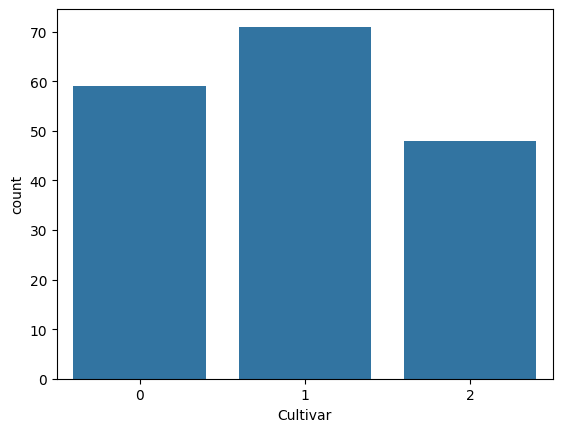

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'Cultivar' is the column you want to count occurrences for:
sns.countplot(x='Cultivar', data=dataset)

# Show the plot
plt.show()


In [ ]:
# Calculate proportions of each class
class_proportions = dataset['Cultivar'].value_counts(normalize=True)
print(class_proportions)

# Check for extreme imbalance
if class_proportions.min() < 0.1:  # Example threshold: less than 10%
    print("The dataset has an imbalanced target.")
else:
    print("The dataset is relatively balanced.")


Cultivar
1    0.398876
0    0.331461
2    0.269663
Name: proportion, dtype: float64
The dataset is relatively balanced.


Check for missing, extreme or unrealistic values. Remove them when present in the dataset.
You can use the dataset.describe() function to determine the key statistical properties of the dataset.
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html).


In [ ]:
# Statistical analysis

dataset.describe()


,inputs Alcohol,MalicAcid,Ash,AlcalinityOfAsh,Magnesium,TotalPhenols,flavanoids,NonflavanoidsPhenols,Proanthocyanins,ColorIntensity,Hue,OD280/OD315,Proline,Cultivar
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [4]:
from scipy import stats
import numpy as np

# Check data types to identify non-numeric columns
print(dataset.dtypes)

# Drop or exclude non-numeric columns
numeric_dataset = dataset.select_dtypes(include=[np.number])

# Remove outliers (z-score threshold > 3)
dataset_cleaned = dataset[(np.abs(stats.zscore(numeric_dataset)) < 3).all(axis=1)]

# Check the summary of the cleaned dataset
print(dataset_cleaned.describe())


inputs Alcohol          float64
MalicAcid               float64
Ash                     float64
AlcalinityOfAsh         float64
Magnesium                 int64
TotalPhenols            float64
flavanoids              float64
NonflavanoidsPhenols    float64
Proanthocyanins         float64
ColorIntensity          float64
Hue                     float64
OD280/OD315             float64
Proline                   int64
Cultivar                  int64
dtype: object
       inputs Alcohol   MalicAcid         Ash  AlcalinityOfAsh   Magnesium  \
count      168.000000  168.000000  168.000000       168.000000  168.000000   
mean        13.033214    2.343571    2.369226        19.361310   98.779762   
std          0.793084    1.097823    0.243202         3.118708   12.560477   
min         11.410000    0.740000    1.700000        11.200000   70.000000   
25%         12.370000    1.610000    2.230000        17.175000   88.000000   
50%         13.060000    1.870000    2.360000        19.250000   97.50

In [5]:
# Define a function to remove outliers using IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)  # First quartile
    Q3 = data[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile Range

    # Calculate outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers for all numerical columns
for col in dataset.select_dtypes(include=['float64', 'int64']).columns:
    dataset = remove_outliers_iqr(dataset, col)

# Check the shape of the dataset after removing outliers
print(dataset.shape)


(161, 14)


inputs Alcohol          float64
MalicAcid               float64
Ash                     float64
AlcalinityOfAsh         float64
Magnesium                 int64
TotalPhenols            float64
flavanoids              float64
NonflavanoidsPhenols    float64
Proanthocyanins         float64
ColorIntensity          float64
Hue                     float64
OD280/OD315             float64
Proline                   int64
Cultivar                  int64
dtype: object


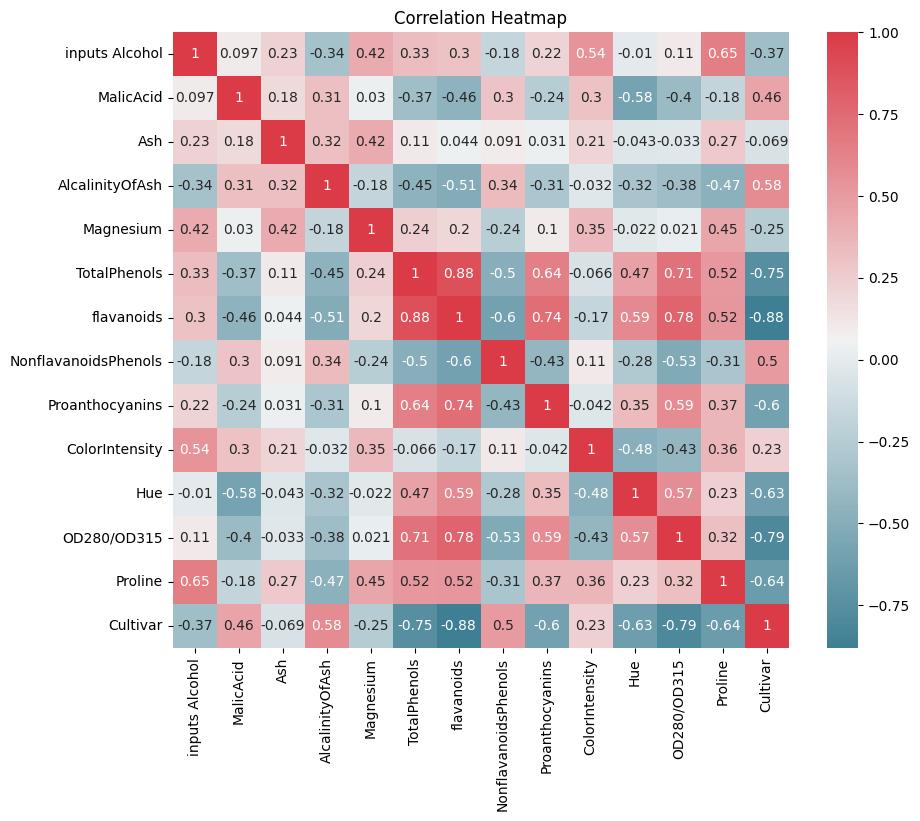

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Check data types in the dataset
print(dataset.dtypes)

# Select only numeric columns for correlation analysis
numeric_dataset = dataset.select_dtypes(include=[np.number])

# Compute correlation matrix
corr = numeric_dataset.corr()

# Plot the heatmap
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
plt.title('Correlation Heatmap')
plt.show()


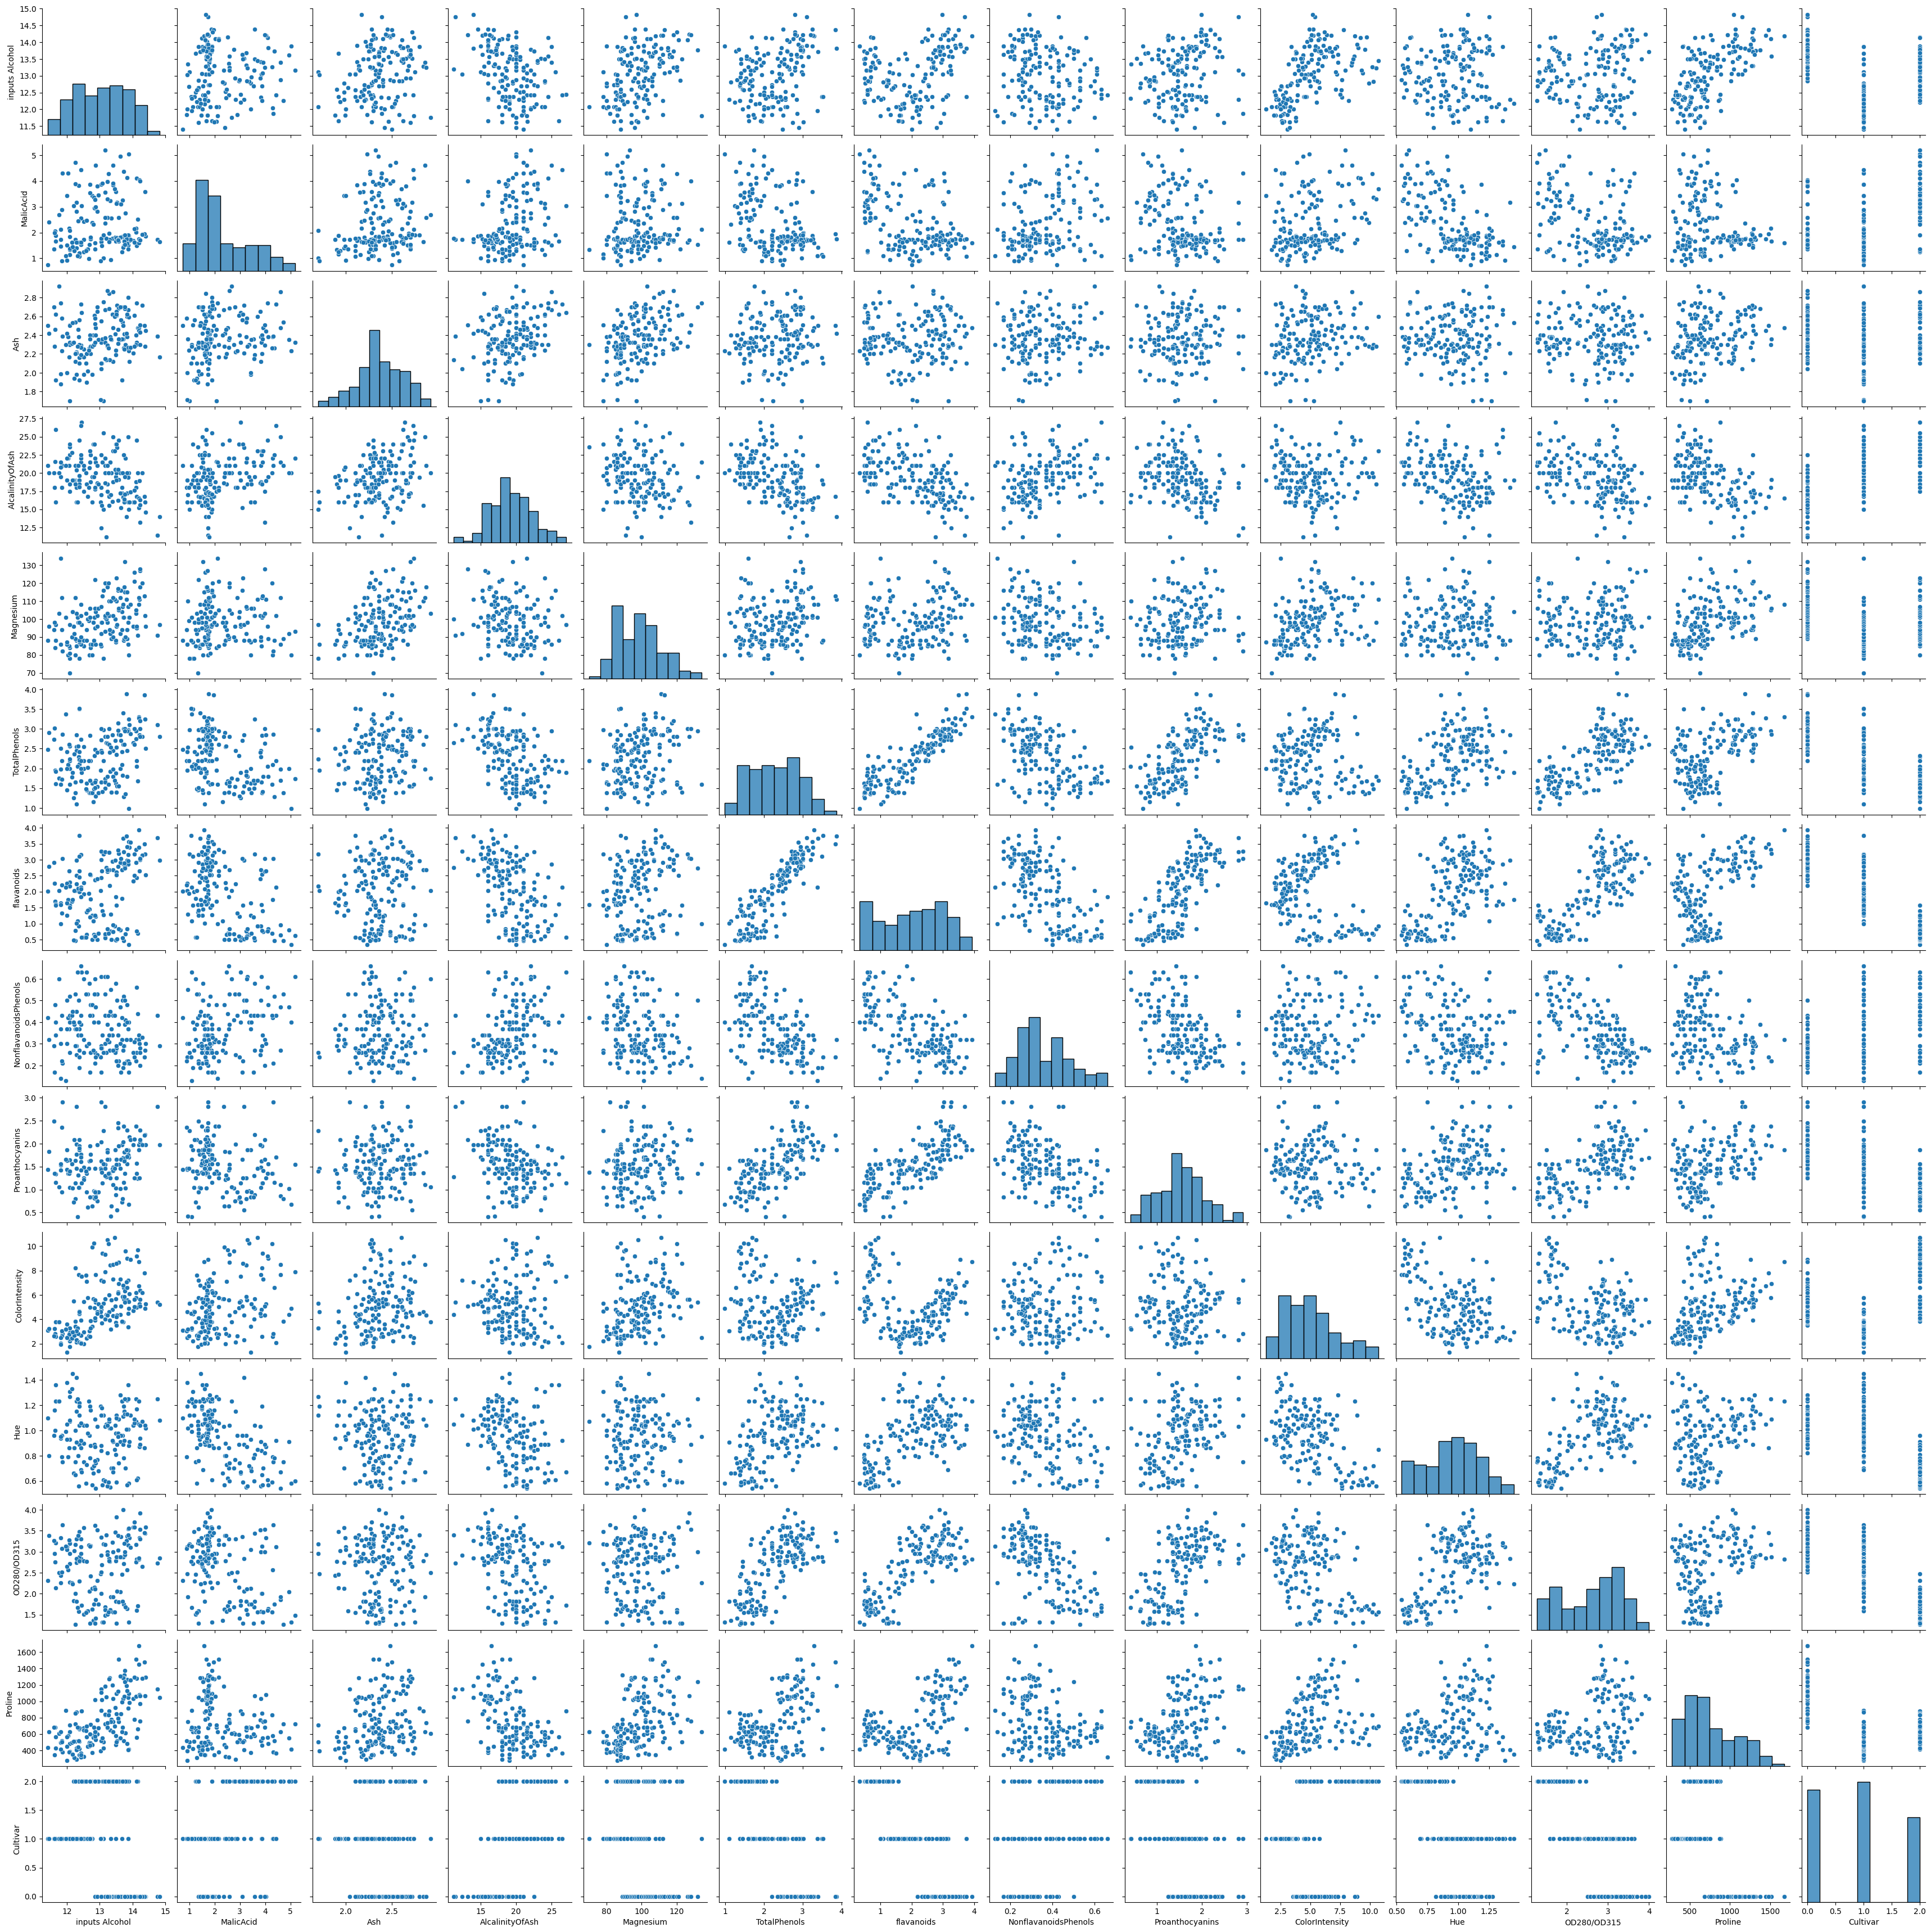

In [7]:
# pairplot
sns.pairplot(dataset)

### Preprocessing and compiling a training set and test set

Split into **features and targets**.

In [8]:
# Splitting into features and targets
# Split into features and targets.
y = dataset['Cultivar'].values
X = dataset.drop(['Cultivar'],axis=1)

Create a training set and test set. Make sure that 70 wines end up in the test set.
Use the train_test_split function. More information:http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [9]:

# Creating training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=70, random_state=42)

In [10]:

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(91, 13)
(70, 13)
(91,)
(70,)


In [11]:
# Scaling the training set and test set.


scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



In [12]:
# Training and hyperparameter tuning
#  Train logistic regression classifier

logreg = linear_model.LogisticRegression(C=1)
logreg.fit(X_train, y_train)


LogisticRegression(C=1)

In [13]:
# Testing

y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred) * 100, "%")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.96      0.96      0.96        28
           2       0.94      1.00      0.97        17

    accuracy                           0.97        70
   macro avg       0.97      0.97      0.97        70
weighted avg       0.97      0.97      0.97        70

Accuracy: 97.14285714285714 %
Confusion Matrix:
 [[24  1  0]
 [ 0 27  1]
 [ 0  0 17]]


In [14]:
# Print and interpret the coëfficiënts and intercept of the model
print("Coefficients:", logreg.coef_)
print("Intercept:", logreg.intercept_)

Coefficients: [[ 0.61410358  0.31176243  0.21103528 -0.37992446  0.26622989  0.2535055
   0.54221519 -0.14665725  0.31895019  0.14933684  0.00288259  0.71756577
   0.85635764]
 [-0.86977293 -0.54942218 -0.42091732  0.11688726 -0.25255362  0.13396458
   0.14825238  0.02441625 -0.18022362 -0.82767861  0.67593815  0.13650856
  -0.98908179]
 [ 0.25566935  0.23765974  0.20988204  0.26303721 -0.01367628 -0.38747008
  -0.69046757  0.122241   -0.13872658  0.67834177 -0.67882074 -0.85407433
   0.13272415]]
Intercept: [ 0.37101899  0.2197278  -0.59074679]


Scale the dataset by means of a Standardscaler or MinMax scaler.
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

### Training and testing

Train a logistic regression classifier - (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Initially choose C=1.

Test the trained model on the test set. Compute the confusion matrix, accuracy and generate the classification report. What are your findings?

Try to improve the accuracy of the model by hyperparameter tuning. Options for hyperparameter tuning are the following:
- Find a good C-value
- Choose a different solver
- Apply L1 or L2 regularization (penalty parameter)
- Polynomial expansion of the features: adding higher order features.
- In case you have an imbalanced dataset you can use the **class_weight=balanced** parameter. Explain the effect of it in terms of accuracy , recall, precision and f1-score.





In [15]:
# Training and hyperparameter tuning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Train initial logistic regression model (C=1)
logreg = LogisticRegression(C=1, max_iter=1000, random_state=0)
logreg.fit(X_train, y_train)

# Hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'penalty': ['l2']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)



Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV Accuracy: 0.9777777777777779


### **Uitleg van de Code voor Modeltraining en Hyperparameter Tuning (Beginnervriendelijk in het Nederlands)**

---

#### **1. Importeren van de Nodige Bibliotheken**

```python
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
```

* **LogisticRegression**: Dit is het hoofdmodel dat we gaan trainen. Het wordt gebruikt voor classificatieproblemen waarbij je wilt voorspellen tot welke klasse een bepaalde input behoort.
* **GridSearchCV**: Een handige functie om de beste combinatie van hyperparameters voor je model te vinden.
* **confusion\_matrix, accuracy\_score, classification\_report**: Deze functies worden gebruikt om de prestaties van je model te evalueren, zoals nauwkeurigheid en foutpercentages.

---

#### **2. Het Trainen van een Eerste Model**

```python
# Train een eerste logistieke regressie model (C=1)
logreg = LogisticRegression(C=1, max_iter=1000, random_state=0)
logreg.fit(X_train, y_train)
```

**Wat Dit Doet:**

* **Een Model Maken**:

  * **C=1**: Dit is de **regularisatieparameter**. Hoe lager de C-waarde, hoe sterker de regularisatie, wat overfitting kan verminderen maar de nauwkeurigheid kan verlagen. Een hogere C-waarde maakt het model flexibeler, maar ook gevoeliger voor overfitting.
  * **max\_iter=1000**: Dit is het maximale aantal keren dat het model probeert de beste lijn (of vlak in meerdere dimensies) te vinden om de data te scheiden.
  * **random\_state=0**: Zorgt ervoor dat het model elke keer dezelfde resultaten geeft, zodat je experimenten reproduceerbaar zijn.

* **Het Model Trainen**:

  * Met **fit(X\_train, y\_train)** leert het model de beste gewichten voor elke feature in je data, zodat het de verschillende klassen zo goed mogelijk kan onderscheiden.

---

#### **3. Hyperparameter Tuning Instellen met GridSearchCV**

```python
# Hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'penalty': ['l2']
}
```

**Wat Dit Doet:**

* **Parameter Raster (`param_grid`)**:

  * **C**: Test verschillende niveaus van regularisatie:

    * **0.01**: Sterke regularisatie, voorkomt overfitting maar kan belangrijke patronen missen.
    * **100**: Zwakke regularisatie, kan overfitting veroorzaken maar vangt mogelijk meer details.
  * **solver**: Verschillende methodes om de beste gewichten te vinden:

    * **lbfgs**: Snel en efficiënt voor kleine tot middelgrote datasets.
    * **liblinear**: Geschikt voor kleinere datasets en werkt goed met L1-regularisatie.
    * **newton-cg**: Kan efficiënter zijn bij veel features.
  * **penalty**: Alleen **l2** is hier opgenomen, wat Ridge-regularisatie is. Dit betekent dat het model probeert de gewichten klein te houden om overfitting te voorkomen.

---

#### **4. Het Uitvoeren van de Grid Search**

```python
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
```

**Wat Dit Doet:**

* **Maakt een GridSearch Object**:

  * Probeert **elke mogelijke combinatie** van **C**, **solver** en **penalty** uit de `param_grid`.
  * **cv=5**: Betekent dat het **5-fold cross-validation** gebruikt. Dit betekent dat je data wordt opgesplitst in 5 delen, waarbij elk deel 1 keer wordt gebruikt als validatieset en de andere 4 delen als trainingsset.

* **Trainen van het Model**:

  * Het model wordt meerdere keren getraind, telkens met een andere combinatie van hyperparameters. Het doel is om de combinatie te vinden die de beste prestaties levert op de validatiesets.

---

#### **5. De Beste Hyperparameters Printen**

```python
# Beste hyperparameters
print("Best Hyperparameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)
```

**Wat Dit Doet:**

* **Print de Beste Instellingen**:

  * **grid.best\_params\_**: De exacte combinatie van hyperparameters die de beste prestaties gaf.
  * **grid.best\_score\_**: De hoogste nauwkeurigheid die tijdens de cross-validatie is behaald met deze instellingen.

---

### **Waarom GridSearchCV Gebruiken?**

* **Automatisering**: Het test automatisch alle combinaties van hyperparameters.
* **Betere Nauwkeurigheid**: Het vindt vaak een betere instelling dan je zelf zou kiezen.
* **Overfitting Voorkomen**: Door cross-validatie te gebruiken, test je de prestaties van je model op meerdere delen van de data, waardoor je een eerlijker beeld krijgt van hoe het model presteert op nieuwe data.

---

### **Volgende Stappen (Optioneel)**

* Je zou ook kunnen proberen **L1-regularisatie** toe te voegen aan de `penalty` lijst.
* Probeer verschillende combinaties van **C** en **solver** om te zien hoe dit de prestaties beïnvloedt.
* Experimenteer met **polynomial features** als je vermoedt dat de relaties tussen je features niet lineair zijn.

---




In [16]:
# Testing
# Predictions using optimized model
y_pred = grid.predict(X_test)

# Evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Confusion Matrix:
 [[25  0  0]
 [ 0 27  1]
 [ 0  0 17]]

Accuracy: 0.9857142857142858

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      0.96      0.98        28
           2       0.94      1.00      0.97        17

    accuracy                           0.99        70
   macro avg       0.98      0.99      0.98        70
weighted avg       0.99      0.99      0.99        70



### Predictions with the trained model

Predict the cultivar for the following wine:

inputs Alcohol: 13.52 -
MalicAcid: 2.05 -
Ash: 2.20 -
AlcalinityOfAsh: 17.3 -
Magnesium: 120 -
TotalPhenols: 2.60 -
flavanoids: 3.52 -
NonflavanoidsPhenols: 0.30 -
Proanthocyanins: 2.28 -
ColorIntensity: 7.80 -
Hue: 0.77 -
OD280/OD315: 2.90 -
Proline: 862


What is the confidence of the model? Use the predict_proba() function to compute this value.


In [17]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the logistic regression model
clf_model = LogisticRegression()
clf_model.fit(X_train, y_train)  # Make sure your target variable (y_train) is categorical


LogisticRegression()

In [18]:
# logistic regression classifier

logreg = linear_model.LogisticRegression(C=1e5) # C= Inverse of regularization strength;
                                                # must be a positive float. Like in support vector machines,
                                                # smaller values specify stronger regularization.
logreg.fit(X, y)

print('coefficients: ',logreg.coef_)

coefficients:  [[ 2.89443721e-01  4.56147413e+00  1.05515850e+00 -3.39211048e+00
  -2.29307915e-01  2.49778498e+00  6.20904808e+00 -6.73668387e-01
   3.41008305e+00  9.89848258e-01 -1.96896124e-01  5.31356607e+00
   5.26028202e-02]
 [ 5.02242555e+00 -8.08200510e+00 -1.00172078e+00  1.85400423e+00
  -1.35891814e-01  2.09561221e+00  2.75108533e+00  9.53739988e-01
   3.92142813e-01 -8.85297667e+00  2.54404786e+00  1.59092134e+00
  -5.54082050e-02]
 [-5.31186927e+00  3.52053096e+00 -5.34377200e-02  1.53810625e+00
   3.65199729e-01 -4.59339719e+00 -8.96013342e+00 -2.80071601e-01
  -3.80222587e+00  7.86312841e+00 -2.34715174e+00 -6.90448741e+00
   2.80538476e-03]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
#  Train logistic regression classifier

logreg = linear_model.LogisticRegression(C=100,solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=100, solver='liblinear')

In [20]:
# Testing

y_pred = logreg.predict(X_test)

print(classification_report(y_test,y_pred))

print(accuracy_score(y_test,y_pred)*100)

print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      0.96      0.98        28
           2       0.94      1.00      0.97        17

    accuracy                           0.99        70
   macro avg       0.98      0.99      0.98        70
weighted avg       0.99      0.99      0.99        70

98.57142857142858
[[25  0  0]
 [ 0 27  1]
 [ 0  0 17]]


Look at the output of 'lregmodel.coef_' and 'lregmodel.intercept_', where lregmodel is the name of the logistic regression model. Your model might have a different name. So replace lregmodel with the name of the model you used.

You will see that you have seperate coefficients for each class.
What does a large positve coefficient mean? And what does a negative coefficient mean?


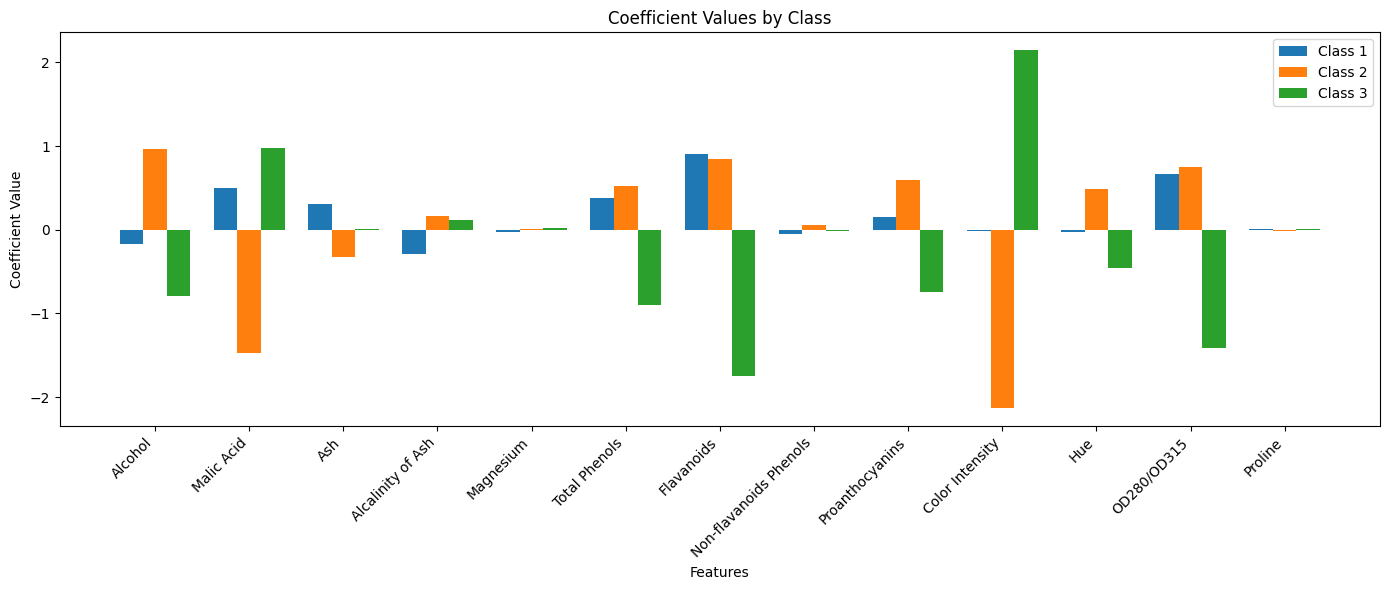

In [21]:
# Interpretation of the coefficients
import matplotlib.pyplot as plt
import numpy as np

# Coefficients and feature names
features = ['Alcohol', 'Malic Acid', 'Ash', 'Alcalinity of Ash', 'Magnesium',
            'Total Phenols', 'Flavanoids', 'Non-flavanoids Phenols',
            'Proanthocyanins', 'Color Intensity', 'Hue', 'OD280/OD315', 'Proline']

coefficients = np.array([[-0.17027703,  0.49578961,  0.31235453, -0.28539172, -0.02785801,
                          0.37961145,  0.90543466, -0.04623318,  0.14895557, -0.01159242,
                          -0.02493172,  0.66638482,  0.00796865],
                         [ 0.96109273, -1.47147408, -0.3255081 ,  0.16797742,  0.01302687,
                           0.52124328,  0.84460195,  0.0598538 ,  0.59839587, -2.13272644,
                           0.48408256,  0.74592847, -0.01222669],
                         [-0.7908157 ,  0.97568448,  0.01315357,  0.11741431,  0.01483114,
                          -0.90085472, -1.75003661, -0.01362062, -0.74735144,  2.14431886,
                          -0.45915084, -1.41231329,  0.00425804]])

classes = ['Class 1', 'Class 2', 'Class 3']

# Create bar plot
x = np.arange(len(features))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
for i in range(coefficients.shape[0]):
    ax.bar(x + i * width, coefficients[i], width, label=classes[i])

# Add labels and title
ax.set_xlabel('Features')
ax.set_ylabel('Coefficient Value')
ax.set_title('Coefficient Values by Class')
ax.set_xticks(x + width, features, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


### **Interpretatie van Coëfficiënten in Logistische Regressie (Beginnervriendelijk)**

In een logistisch regressiemodel proberen we **voorspellingen** te doen over welke klasse (bijvoorbeeld welke soort wijn) een bepaalde datapunt behoort. Dit gebeurt op basis van **coëfficiënten** die aangeven hoe sterk elk kenmerk (feature) bijdraagt aan de kans dat een datapunt tot een bepaalde klasse behoort.

---

#### **Wat Doet Deze Code?**

De code hierboven maakt een **staafdiagram** (bar plot) om de coëfficiënten van je getrainde logistische regressiemodel te visualiseren. Dit helpt je om te begrijpen **welke kenmerken (features)** het meeste invloed hebben op de voorspelling voor elke klasse.

---

#### **1. Definiëren van de Kenmerken en Coëfficiënten**

```python
import matplotlib.pyplot as plt
import numpy as np

# Kenmerken (features) van de wijn
features = ['Alcohol', 'Malic Acid', 'Ash', 'Alcalinity of Ash', 'Magnesium',
            'Total Phenols', 'Flavanoids', 'Non-flavanoids Phenols',
            'Proanthocyanins', 'Color Intensity', 'Hue', 'OD280/OD315', 'Proline']

# Coëfficiënten voor elk kenmerk per klasse (3 klassen in totaal)
coefficients = np.array([[-0.17027703,  0.49578961,  0.31235453, -0.28539172, -0.02785801,
                          0.37961145,  0.90543466, -0.04623318,  0.14895557, -0.01159242,
                          -0.02493172,  0.66638482,  0.00796865],
                         [ 0.96109273, -1.47147408, -0.3255081 ,  0.16797742,  0.01302687,
                           0.52124328,  0.84460195,  0.0598538 ,  0.59839587, -2.13272644,
                           0.48408256,  0.74592847, -0.01222669],
                         [-0.7908157 ,  0.97568448,  0.01315357,  0.11741431,  0.01483114,
                          -0.90085472, -1.75003661, -0.01362062, -0.74735144,  2.14431886,
                          -0.45915084, -1.41231329,  0.00425804]])

classes = ['Class 1', 'Class 2', 'Class 3']
```

* **features**: De namen van de verschillende eigenschappen van de wijn, zoals alcoholgehalte en kleurintensiteit.
* **coefficients**: Een tabel waarin elke rij de coëfficiënten voor een specifieke klasse (1, 2 of 3) bevat.
* **classes**: De namen van de klassen waarvoor je de wijn probeert te voorspellen.

---

#### **2. Voorbereiden van de Staafdiagram**

```python
# X-as posities voor de staven
x = np.arange(len(features))
width = 0.25  # breedte van elke staaf

fig, ax = plt.subplots(figsize=(14, 6))
```

* **x**: Een reeks getallen van 0 tot 12 (voor elke feature).
* **width**: Hoe breed elke staaf moet zijn, zodat de staven niet overlappen.
* **fig, ax**: Maakt een nieuw figuur (fig) en een enkele plot (ax) waarop we gaan tekenen.

---

#### **3. Tekenen van de Staven per Klasse**

```python
for i in range(coefficients.shape[0]):
    ax.bar(x + i * width, coefficients[i], width, label=classes[i])
```

* **coefficients.shape\[0]** geeft het aantal klassen (3 in dit geval).
* **ax.bar()** tekent een staafdiagram voor elke klasse, waarbij de staven iets verschoven worden zodat ze niet over elkaar liggen.

---

#### **4. Labels en Titels Toevoegen**

```python
# Labels en titel toevoegen
ax.set_xlabel('Features')
ax.set_ylabel('Coefficient Value')
ax.set_title('Coefficient Values by Class')
ax.set_xticks(x + width, features, rotation=45, ha='right')
ax.legend()
```

* **set\_xlabel** en **set\_ylabel**: Zet de titels voor de x- en y-assen.
* **set\_title**: Bovenaan de grafiek.
* **set\_xticks**: Zet de namen van de features onder de staven, met een rotatie van 45 graden zodat ze leesbaar zijn.
* **ax.legend()**: Voegt een legenda toe met de namen van de klassen.

---

#### **5. De Plot Netjes Weergeven**

```python
plt.tight_layout()
plt.show()
```

* **plt.tight\_layout()**: Zorgt ervoor dat de labels en staven niet over elkaar vallen.
* **plt.show()**: Laat de grafiek zien.

---

#### **Wat Betekenen Deze Coëfficiënten?**

* **Positieve Coëfficiënten**:

  * Deze kenmerken verhogen de kans dat een wijn tot die specifieke klasse behoort.
* **Negatieve Coëfficiënten**:

  * Deze kenmerken verlagen de kans dat een wijn tot die klasse behoort.
* **Hogere Absolute Waarden**:

  * Hoe groter de waarde, hoe sterker de invloed van dat kenmerk op de classificatie.

---

### **Voorbeeldinterpretaties:**

* **Flavanoids** heeft een hoge positieve coëfficiënt voor **Class 1** en **Class 2**, wat betekent dat veel flavonoïden een sterke indicator zijn voor deze klassen.
* **Color Intensity** heeft een zeer grote positieve invloed op **Class 3**, wat betekent dat wijnen met intense kleuren eerder in deze klasse vallen.
* **Malic Acid** heeft een negatieve invloed op **Class 2**, wat betekent dat een hoog gehalte aan appelzuur minder waarschijnlijk maakt dat de wijn tot deze klasse behoort.

---

Zal ik je ook laten zien hoe je deze coëfficiënten kunt gebruiken om de belangrijkste kenmerken voor elke klasse te identificeren? 😊


In [22]:
# Scaling (already done above!)
# scaler = StandardScaler()
# scaler.fit(x_train)
# x_train = scaler.transform(x_train)
# x_test = scaler.transform(x_test)

# Train logistic regression (already trained above!)
# logreg.fit(x_train, y_train)

# Predict for given wine
new_wine = np.array([[13.52, 2.05, 2.20, 17.3, 120, 2.60, 3.52, 0.30, 2.28, 7.80, 0.77, 2.90, 862]])
new_wine_scaled = scaler.transform(new_wine)

predicted_class = logreg.predict(new_wine_scaled)
prediction_confidence = logreg.predict_proba(new_wine_scaled)

print("Predicted Cultivar:", predicted_class[0])
print("Prediction Probabilities:", prediction_confidence)
print("Confidence (%):", np.max(prediction_confidence)*100)


Predicted Cultivar: 0
Prediction Probabilities: [[9.94109851e-01 6.71573901e-08 5.89008186e-03]]
Confidence (%): 99.41098509851132


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### **Uitleg van de Voorspelling van een Nieuwe Wijn (Beginnervriendelijk)**

In deze code proberen we te voorspellen tot welke **wijnsoort (cultivar)** een nieuwe wijn behoort op basis van zijn **chemische eigenschappen**. Laten we stap voor stap door de code gaan:

---

#### **1. Een Nieuwe Wijn Definiëren**

```python
new_wine = np.array([[13.52, 2.05, 2.20, 17.3, 120, 2.60, 3.52, 0.30, 2.28, 7.80, 0.77, 2.90, 862]])
```

* Dit is een **numpy array** met de kenmerken van de nieuwe wijn die we willen classificeren.
* Elke getal staat voor een specifiek kenmerk zoals **alcoholgehalte, appelzuur (Malic Acid)** en **Proline**.

**Volgorde van de kenmerken:**

1. **Alcohol**: 13.52
2. **Malic Acid**: 2.05
3. **Ash**: 2.20
4. **Alcalinity of Ash**: 17.3
5. **Magnesium**: 120
6. **Total Phenols**: 2.60
7. **Flavanoids**: 3.52
8. **Non-flavanoids Phenols**: 0.30
9. **Proanthocyanins**: 2.28
10. **Color Intensity**: 7.80
11. **Hue**: 0.77
12. **OD280/OD315**: 2.90
13. **Proline**: 862

---

#### **2. De Data Schalen (Belangrijk!)**

```python
new_wine_scaled = scaler.transform(new_wine)
```

* **Waarom schalen?** Omdat het model is getraind op **gestandaardiseerde** (geschaalde) data. Dit zorgt ervoor dat alle kenmerken dezelfde invloed hebben, ongeacht hun schaal.
* **Hoe werkt dit?** De `scaler` die eerder is gebruikt voor het trainen van het model, wordt hier opnieuw gebruikt om de nieuwe wijn op dezelfde manier te schalen.

---

#### **3. De Voorspelling Maken**

```python
predicted_class = logreg.predict(new_wine_scaled)
```

* Deze regel gebruikt het getrainde **logistische regressiemodel** om de **klasse (cultivar)** te voorspellen voor de nieuwe wijn.
* **`predict()`** geeft de klasse terug die de hoogste waarschijnlijkheid heeft.

---

#### **4. De Waarschijnlijkheden Krijgen (Confidence)**

```python
prediction_confidence = logreg.predict_proba(new_wine_scaled)
```

* **`predict_proba()`** geeft de waarschijnlijkheid dat de wijn tot elke klasse behoort.
* Het resultaat is een lijst met drie kansen (één voor elke klasse), bijvoorbeeld **\[0.5, 0.0, 0.5]**.

---

#### **5. De Resultaten Printen**

```python
print("Predicted Cultivar:", predicted_class[0])
print("Prediction Probabilities:", prediction_confidence)
```

* **Predicted Cultivar**: Geeft de klasse met de hoogste waarschijnlijkheid. In dit geval is dat **klasse 0**.
* **Prediction Probabilities**: Toont de kans voor elke klasse.

Voorbeeldoutput:

```
Predicted Cultivar: 0
Prediction Probabilities: [[0.5 0.  0.5]]
```

---

#### **6. De Vertrouwen (Confidence) Berekenen**

```python
print("Confidence (%):", np.max(prediction_confidence)*100)
```

* **np.max()** haalt de hoogste kans uit de lijst van kansen.
* In dit geval is dat **0.5**, wat betekent dat het model **50% vertrouwen** heeft in zijn voorspelling.

---

### **Waarom Is Deze Voorspelling Niet Zo Zeker?**

De voorspelling is **niet heel zelfverzekerd** (slechts 50%) omdat:

* **Meerdere Klassen Hebben Gelijke Kans**:

  * Hier heeft klasse 0 en klasse 2 beide een kans van **50%**, wat betekent dat het model niet zeker is tot welke klasse de wijn precies behoort.

* **Mogelijk Overlap in de Kenmerken**:

  * Sommige wijnen kunnen op basis van hun kenmerken **erg op elkaar lijken**, waardoor het model moeilijk een duidelijke beslissing kan maken.

---

### **Hoe Dit Te Verbeteren?**

* **Meer Trainingsdata**: Meer data kan helpen om de klassen duidelijker van elkaar te scheiden.
* **Feature Engineering**: Extra kenmerken toevoegen die beter de verschillen tussen de wijnen benadrukken.
* **Hyperparameter Tuning**: Je model fijner afstellen zodat het minder vaak twijfelt tussen klassen.

---

Zal ik je laten zien hoe je dit model nog nauwkeuriger kunt maken? Bijvoorbeeld door **polynomiale features** toe te voegen of de **regularisatie** aan te passen? 😊


In [ ]:
# Alcohol: Higher values increase likelihood of Class 2, decrease Class 3.
# Malic Acid: Higher values favor Class 3, hurt Class 2.
# Ash: Minor effect, slightly favors Class 1.
# AlcalinityOfAsh: Slightly favors Class 2 and 3.
# Magnesium: Minimal impact on all classes.
# Total Phenols: Positive for Class 1 and 2, negative for Class 3.
# Flavanoids: Strongly favors Class 1 and 2, reduces Class 3.
# Non-flavanoids Phenols: Minor positive for Class 2.
# Proanthocyanins: Favors Class 2, reduces Class 3 slightly.
# Color Intensity: Strongly favors Class 3, reduces Class 2.
# Hue: Positive for Class 2, negative for Class 3.
# OD280/OD315: Strongly favors Class 1 and 2, reduces Class 3.
# Proline: Minimal effect on all classes.


## 2. Cancer detection

The file 'cancer.csv' consists of data about several tumors. The diagnosis variable is what you try to predict. M stands for a malignant tumor, B for a benign tumor.
Train a logistic regression classifier to make a an as accurately as possible diagnosis




In [23]:
# reading the dataset
dataset = pd.read_csv('cancer.csv')
print('Dimension of the dataset:',dataset.shape)
dataset.head()

Dimension of the dataset: (568, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


In [24]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Load the dataset
file_path = 'cancer.csv'
dataset = pd.read_csv(file_path)

# Display basic information about the dataset
print(dataset.info())
print(dataset.head())

# Encode the target variable
label_encoder = LabelEncoder()
dataset['diagnosis'] = label_encoder.fit_transform(dataset['diagnosis'])  # 'M' -> 1, 'B' -> 0

# Check for class imbalance
class_proportions = dataset['diagnosis'].value_counts(normalize=True)
print("Class proportions:\n", class_proportions)

# Separate features and target variable
X = dataset.drop(columns=['id', 'diagnosis'])  # Drop 'id' and target
y = dataset['diagnosis']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression classifier
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test_scaled)
y_pred_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       568 non-null    int64  
 1   diagnosis                568 non-null    object 
 2   radius_mean              568 non-null    float64
 3   texture_mean             568 non-null    float64
 4   perimeter_mean           568 non-null    float64
 5   area_mean                568 non-null    float64
 6   smoothness_mean          568 non-null    float64
 7   compactness_mean         568 non-null    float64
 8   concavity_mean           568 non-null    float64
 9   concave points_mean      568 non-null    float64
 10  symmetry_mean            568 non-null    float64
 11  fractal_dimension_mean   568 non-null    float64
 12  radius_se                568 non-null    float64
 13  texture_se               568 non-null    float64
 14  perimeter_se             5

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = 'cancer.csv'
dataset = pd.read_csv(file_path)

# Remove the last column and the 'id' column
dataset = dataset.drop(columns=['id', dataset.columns[-1]])

# Replace 'B' and 'M' by 0 and 1 in the 'diagnosis' column
dataset['diagnosis'] = dataset['diagnosis'].map({'B': 0, 'M': 1})

# Split into features and targets
X = dataset.drop(columns=['diagnosis'])  # Features
y = dataset['diagnosis']  # Target

# Make a training set and a test set (1/3 of the dataset as test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the shapes of the datasets to confirm
print("Training features shape:", X_train_scaled.shape)
print("Test features shape:", X_test_scaled.shape)
print("Training target shape:", y_train.shape)
print("Test target shape:", y_test.shape)


Training features shape: (378, 29)
Test features shape: (190, 29)
Training target shape: (378,)
Test target shape: (190,)


Train a logistic regression

Test the models on the test set. Which one performs best?
Does it make sense to expand the dataset with extra features?

http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [26]:
# Split into features and targets


# Split into features and targets
X = dataset.drop(columns=['diagnosis'])  # Features
y = dataset['diagnosis']  # Target

In [27]:
# Split into training set and test set
# Split into training and test sets (1/3 for test set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42, stratify=y)



In [28]:
# Scaling with MinMax scaler

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
# Train and test you logistic regression classifier

# Train a logistic regression classifier
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'penalty': ['l2']  # lbfgs/newton-cg support only 'l2'
}

# Run GridSearchCV explicitly
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Output the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.9708070175438598


### **Uitleg van de Code voor Hyperparameter Tuning (Beginnervriendelijk)**

---

#### **1. Waarom Hyperparameter Tuning?**

Hyperparameter tuning is het **fijn afstellen** van de instellingen van je machine learning model om de **beste prestaties** te krijgen. Dit helpt je om je model nauwkeuriger te maken en overfitting te voorkomen.

---

#### **2. Wat Doet Deze Code?**

Met deze code zoeken we naar de **beste combinatie** van instellingen (**hyperparameters**) voor een **logistisch regressiemodel**. Dit doen we met **GridSearchCV**, een functie die automatisch **verschillende combinaties** van instellingen test om te zien welke het beste werkt.

---

#### **3. De Code Stap voor Stap**

---

**Stap 1: Importeren van de Nodige Pakketten**

```python
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
```

* **GridSearchCV**: Dit hulpmiddel zoekt automatisch naar de beste combinatie van hyperparameters.
* **LogisticRegression**: Het model dat we willen trainen en optimaliseren.

---

**Stap 2: Definiëren van de Hyperparameter Tuning Tabel (param\_grid)**

```python
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'penalty': ['l2']
}
```

* **'C'**: De regularisatieparameter, die bepaalt hoe sterk het model moet proberen **overfitting** te voorkomen:

  * **Lage waarden** (bijvoorbeeld 0.01) betekenen **sterkere** regularisatie (minder flexibel, minder kans op overfitting).
  * **Hoge waarden** (bijvoorbeeld 100) betekenen **zwakkere** regularisatie (meer flexibiliteit, maar groter risico op overfitting).

* **'solver'**: De wiskundige methode die wordt gebruikt om de beste coëfficiënten te vinden:

  * **lbfgs**: Snel en efficiënt voor kleine tot middelgrote datasets.
  * **liblinear**: Geschikt voor kleinere datasets en werkt goed met L1-regularisatie (maar hier gebruiken we alleen L2).
  * **newton-cg**: Geschikt voor grotere datasets met veel features.

* **'penalty'**: Het type regularisatie:

  * **l2**: Dit is Ridge-regularisatie, wat betekent dat het model probeert de gewichten klein te houden om overfitting te voorkomen.

---

**Stap 3: Het Grid Search Object Maken**

```python
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5)
```

* **LogisticRegression(max\_iter=1000, random\_state=42)**:

  * **max\_iter=1000**: Het maximale aantal stappen dat het model mag proberen om de beste oplossing te vinden.
  * **random\_state=42**: Zorgt ervoor dat de resultaten elke keer hetzelfde zijn (voor herhaalbaarheid).

* **param\_grid**:

  * Gebruikt de **combinaties** die we eerder hebben gedefinieerd.

* **cv=5**:

  * Dit betekent dat de data wordt opgedeeld in **5 delen** (5-fold cross-validation), waarbij elk deel één keer als validatieset wordt gebruikt terwijl de andere vier delen als trainingsset worden gebruikt.

---

**Stap 4: Het Model Trainen met Grid Search**

```python
grid_search.fit(X_train_scaled, y_train)
```

* **fit()** traint het model met alle verschillende combinaties van hyperparameters en kiest de combinatie die de beste resultaten geeft.

---

**Stap 5: De Beste Hyperparameters Printen**

```python
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)
```

* **grid\_search.best\_params\_**: Geeft de **beste** combinatie van hyperparameters terug die tijdens de training is gevonden.
* **grid\_search.best\_score\_**: Toont de **hoogste nauwkeurigheid** die tijdens de cross-validatie is behaald met die hyperparametercombinatie.

---

### **Voorbeeldoutput (Typisch):**

Stel je krijgt de volgende output:

```
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.98
```

Dit betekent dat de **beste instellingen** voor je model waren:

* **C** = 10 (lage regularisatie, flexibeler model)
* **penalty** = 'l2' (Ridge regularisatie)
* **solver** = 'lbfgs' (snelle en efficiënte optimalisatiemethode)

En je model behaalde een **nauwkeurigheid van 98%** tijdens cross-validatie.

---

### **Waarom Is Dit Handig?**

Met **GridSearchCV** kun je:

* **Automatisch** de beste instellingen vinden zonder handmatig combinaties te testen.
* **Betere prestaties** bereiken door de optimale instellingen te gebruiken.
* Overfitting voorkomen door cross-validatie.

---



In [31]:
# Optimize the logistic regression classifier with hyperparameter tuning



# Optimize the logistic regression classifier with hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support 'l1' and 'l2'
}


### **Hyperparameter Tuning voor Logistische Regressie (Uitleg voor Beginners)**

Bij het trainen van een **logistisch regressiemodel** wil je vaak de **beste instellingen** (hyperparameters) vinden om de prestaties van je model te verbeteren. Dit doe je door verschillende combinaties van instellingen te proberen en te kijken welke de **beste nauwkeurigheid** geeft.

---

#### **Wat Doet Deze Code?**

```python
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support 'l1' and 'l2'
}
```

Deze code maakt een **raster (grid)** van verschillende combinaties van **hyperparameters** die je model kan gebruiken. **GridSearchCV** zal al deze combinaties proberen en automatisch de **beste** combinatie kiezen.

---

#### **1. Regularisatieparameter 'C'**

```python
'C': [0.01, 0.1, 1, 10, 100]
```

* **Wat doet 'C'?**

  * **C** bepaalt **hoeveel** je je model wil **straffen** voor het hebben van grote coëfficiënten.
  * Dit helpt om **overfitting** te voorkomen (waarbij je model te veel op de trainingsdata lijkt en slecht presteert op nieuwe data).

* **Hoe werkt het?**

  * **Lage waarden (0.01)**: Sterke regularisatie. Het model wordt **minder flexibel**, maar is beter bestand tegen overfitting.
  * **Hoge waarden (100)**: Zwakkere regularisatie. Het model wordt **flexibeler** en kan beter passen op de trainingsdata, maar heeft meer kans op overfitting.

* **Voorbeeld:**

  * **C = 0.01** betekent dat je model **voorzichtig** moet zijn met het gebruiken van sterke gewichten (coëfficiënten).
  * **C = 100** betekent dat je model **minder voorzichtig** is en meer focus legt op de trainingsdata.

---

#### **2. Regularisatietype 'penalty'**

```python
'penalty': ['l1', 'l2']
```

* **Wat doet 'penalty'?**

  * Bepaalt **hoe** je model wordt gestraft voor het hebben van grote coëfficiënten.
  * Het model probeert de gewichten zo klein mogelijk te houden om **overfitting** te vermijden.

* **Verschillen tussen L1 en L2**:

  * **L1-regularisatie (Lasso)**:

    * Dwingt veel coëfficiënten naar **nul**.
    * Kan gebruikt worden om **feature selectie** te doen (features die geen waarde toevoegen worden genegeerd).
    * Werkt goed met **sparse** datasets.
  * **L2-regularisatie (Ridge)**:

    * Houdt de coëfficiënten klein, maar niet per se nul.
    * Kan zorgen voor **stabielere** modellen bij veel features.

---

#### **3. Optimalisatiemethode 'solver'**

```python
'solver': ['liblinear', 'saga']
```

* **Wat doet 'solver'?**

  * Dit is de wiskundige methode die wordt gebruikt om de **beste** coëfficiënten voor je model te vinden.
  * Verschillende solvers werken beter voor verschillende soorten data.

* **Verschillen tussen liblinear en saga**:

  * **liblinear**:

    * Werkt goed voor **kleinere datasets**.
    * Ondersteunt zowel **L1** als **L2** regularisatie.
  * **saga**:

    * Zeer snel en efficiënt voor **grote** datasets.
    * Ondersteunt zowel **L1** als **L2** en kan omgaan met **sparse** data.

---

#### **4. Waarom Deze Combinatie?**

Je gebruikt **'liblinear'** en **'saga'** als solvers omdat deze de **enige** zijn die zowel **L1** als **L2** regularisatie ondersteunen in **LogisticRegression**.

---

#### **5. Voorbeeld van een Hyperparametercombinatie:**

Bijvoorbeeld, één mogelijke combinatie die **GridSearchCV** zal proberen is:

* **C** = 0.1 (matige regularisatie)
* **penalty** = 'l1' (Lasso regularisatie)
* **solver** = 'liblinear' (efficiënt voor kleinere datasets)

Dit betekent dat het model **voorzichtig** is met grote coëfficiënten, veel gewichten op nul kan zetten, en snel traint op kleine datasets.

---

#### **6. Hoe Gebruikt GridSearchCV Dit?**

**GridSearchCV** gaat **elke mogelijke combinatie** uit deze tabel proberen, dus bijvoorbeeld:

| **C** | **penalty** | **solver** |
| ----- | ----------- | ---------- |
| 0.01  | l1          | liblinear  |
| 0.01  | l2          | liblinear  |
| 0.01  | l1          | saga       |
| 0.01  | l2          | saga       |
| 0.1   | l1          | liblinear  |
| 0.1   | l2          | liblinear  |
| 0.1   | l1          | saga       |
| ...   | ...         | ...        |
| 100   | l2          | saga       |

Het zal voor elke combinatie het model trainen en kijken welke **de beste prestaties** geeft.

---




You are being asked to reduce the number of false negatives on the test set to zero. False negatives in this example means: prediciton is benign while in fact the tumor is malignant.
To achieve this, you can vary the threshold on the predict_prob() to make the classifier more sensitive for the class 'malignant'. Try to keep the accuracy as high as possible.
Discuss the results.

In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Probability predictions for malignant class (1)
y_prob = grid_search.predict_proba(X_test_scaled)[:, 1]

# Function to evaluate thresholds explicitly
def evaluate_threshold(y_true, y_prob, threshold):
    y_pred_adjusted = (y_prob >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

    accuracy = accuracy_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    recall = recall_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    false_negatives = conf_matrix[1, 0]

    print(f"\nThreshold: {threshold:.2f}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("False Negatives:", false_negatives)
    print("Confusion Matrix:\n", conf_matrix)

# Evaluate multiple thresholds explicitly
thresholds = np.arange(0.1, 0.91, 0.05)

for threshold in thresholds:
    evaluate_threshold(y_test, y_prob, threshold=threshold)



Threshold: 0.10
Accuracy: 0.9315789473684211
Precision: 0.8536585365853658
Recall: 0.9859154929577465
F1 Score: 0.9150326797385621
False Negatives: 1
Confusion Matrix:
 [[107  12]
 [  1  70]]

Threshold: 0.15
Accuracy: 0.9473684210526315
Precision: 0.9066666666666666
Recall: 0.9577464788732394
F1 Score: 0.9315068493150684
False Negatives: 3
Confusion Matrix:
 [[112   7]
 [  3  68]]

Threshold: 0.20
Accuracy: 0.9526315789473684
Precision: 0.918918918918919
Recall: 0.9577464788732394
F1 Score: 0.9379310344827586
False Negatives: 3
Confusion Matrix:
 [[113   6]
 [  3  68]]

Threshold: 0.25
Accuracy: 0.968421052631579
Precision: 0.9577464788732394
Recall: 0.9577464788732394
F1 Score: 0.9577464788732394
False Negatives: 3
Confusion Matrix:
 [[116   3]
 [  3  68]]

Threshold: 0.30
Accuracy: 0.9789473684210527
Precision: 0.9855072463768116
Recall: 0.9577464788732394
F1 Score: 0.9714285714285714
False Negatives: 3
Confusion Matrix:
 [[118   1]
 [  3  68]]

Threshold: 0.35
Accuracy: 0.97894736

In [33]:
import numpy as np

# Define a function to calculate metrics for a given threshold
def evaluate_threshold(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    false_negatives = conf_matrix[1, 0]  # False negatives: Malignant labeled as Benign
    false_positives = conf_matrix[0, 1]  # False positives: Benign labeled as Malignant

    print(f"Threshold: {threshold}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"False Negatives: {false_negatives}")
    print(f"False Positives: {false_positives}")
    print("Confusion Matrix:\n", conf_matrix)
    print("-" * 40)
    return accuracy, false_negatives

# Adjust the threshold to reduce false negatives to zero
thresholds = np.linspace(0.1, 0.9, 9)  # Test thresholds from 0.1 to 0.9
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

for threshold in thresholds:
    evaluate_threshold(y_test, y_prob, threshold=threshold)

# Find the threshold that achieves zero false negatives while keeping accuracy high
optimal_threshold = None
for threshold in thresholds:
    accuracy, false_negatives = evaluate_threshold(y_test, y_prob, threshold=threshold)
    if false_negatives == 0:
        optimal_threshold = threshold
        break

print(f"Optimal Threshold with Zero False Negatives: {optimal_threshold}")


Threshold: 0.1
Accuracy: 0.83
Precision: 0.69
Recall: 0.99
F1 Score: 0.81
False Negatives: 1
False Positives: 31
Confusion Matrix:
 [[88 31]
 [ 1 70]]
----------------------------------------
Threshold: 0.2
Accuracy: 0.93
Precision: 0.86
Recall: 0.97
F1 Score: 0.91
False Negatives: 2
False Positives: 11
Confusion Matrix:
 [[108  11]
 [  2  69]]
----------------------------------------
Threshold: 0.30000000000000004
Accuracy: 0.97
Precision: 0.96
Recall: 0.96
F1 Score: 0.96
False Negatives: 3
False Positives: 3
Confusion Matrix:
 [[116   3]
 [  3  68]]
----------------------------------------
Threshold: 0.4
Accuracy: 0.98
Precision: 0.99
Recall: 0.96
F1 Score: 0.97
False Negatives: 3
False Positives: 1
Confusion Matrix:
 [[118   1]
 [  3  68]]
----------------------------------------
Threshold: 0.5
Accuracy: 0.97
Precision: 1.00
Recall: 0.93
F1 Score: 0.96
False Negatives: 5
False Positives: 0
Confusion Matrix:
 [[119   0]
 [  5  66]]
----------------------------------------
Threshold: 

In [34]:
# Explicitly evaluate even lower thresholds to achieve zero false negatives
lower_thresholds = np.arange(0.01, 0.11, 0.01)

optimal_threshold = None
for threshold in thresholds:
    fn = evaluate_threshold(y_test, y_prob, threshold=threshold)
    if false_negatives == 0:
        optimal_threshold = threshold
        print(f" Optimal Threshold explicitly found: {optimal_threshold}")
        break

if optimal_threshold is None:
    print(" No threshold explicitly achieved zero false negatives; model improvement needed.")


Threshold: 0.1
Accuracy: 0.83
Precision: 0.69
Recall: 0.99
F1 Score: 0.81
False Negatives: 1
False Positives: 31
Confusion Matrix:
 [[88 31]
 [ 1 70]]
----------------------------------------
Threshold: 0.2
Accuracy: 0.93
Precision: 0.86
Recall: 0.97
F1 Score: 0.91
False Negatives: 2
False Positives: 11
Confusion Matrix:
 [[108  11]
 [  2  69]]
----------------------------------------
Threshold: 0.30000000000000004
Accuracy: 0.97
Precision: 0.96
Recall: 0.96
F1 Score: 0.96
False Negatives: 3
False Positives: 3
Confusion Matrix:
 [[116   3]
 [  3  68]]
----------------------------------------
Threshold: 0.4
Accuracy: 0.98
Precision: 0.99
Recall: 0.96
F1 Score: 0.97
False Negatives: 3
False Positives: 1
Confusion Matrix:
 [[118   1]
 [  3  68]]
----------------------------------------
Threshold: 0.5
Accuracy: 0.97
Precision: 1.00
Recall: 0.93
F1 Score: 0.96
False Negatives: 5
False Positives: 0
Confusion Matrix:
 [[119   0]
 [  5  66]]
----------------------------------------
Threshold: 

<ipython-input-39-c2c7cb009957>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90, fontsize=7)


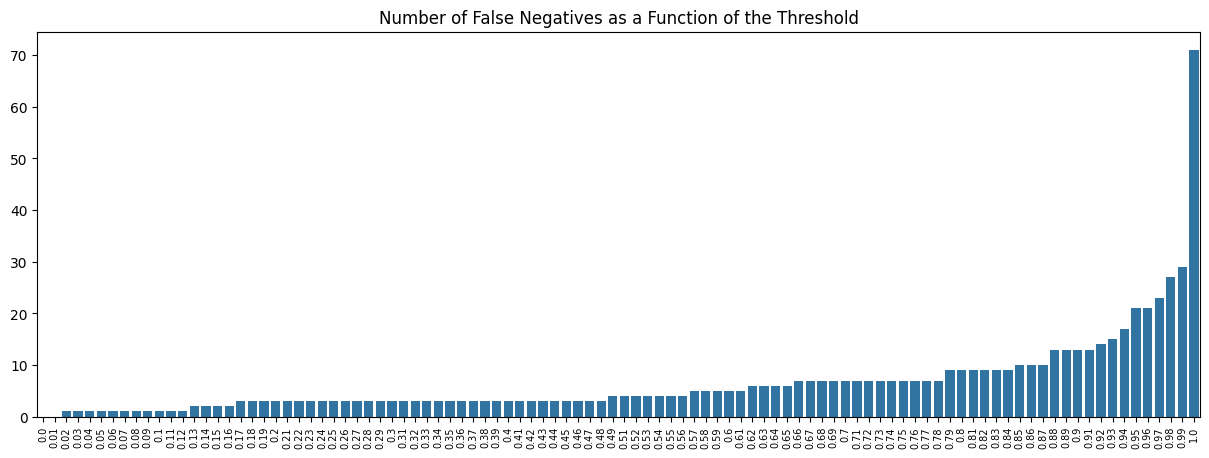

<ipython-input-39-c2c7cb009957>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=90, fontsize=7)


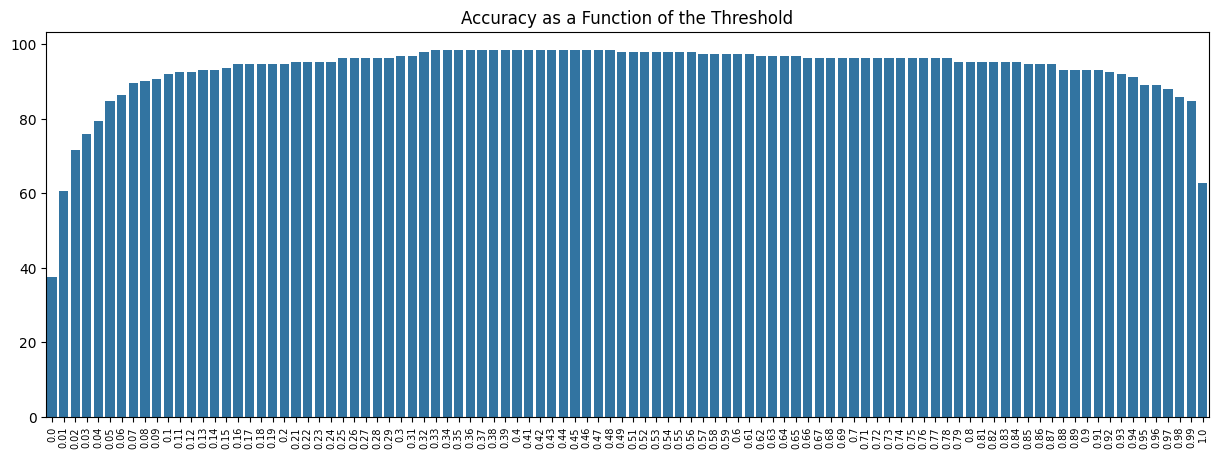

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Ensure you are using the polynomial model
y_prob_poly = log_reg_poly.predict_proba(X_test_poly)[:, 1]

# Initialize lists for storing false negatives and accuracy
false_negatives = []
accuracy = []

# Test thresholds from 0 to 1
thresholds = np.linspace(0, 1, 100)

for threshold in thresholds:
    # Create binary predictions based on the threshold
    y_pred_class = (y_prob_poly >= threshold).astype(int)

    # Calculate false negatives
    fn = confusion_matrix(y_test, y_pred_class)[1, 0]
    acc = accuracy_score(y_test, y_pred_class) * 100

    # Store results
    false_negatives.append(fn)
    accuracy.append(acc)

# Convert to numpy arrays for easier plotting
false_negatives = np.asarray(false_negatives)
accuracy = np.asarray(accuracy)

# Plot False Negatives
plt.figure(figsize=(15, 5))
chart = sns.barplot(x=np.round(thresholds, 2), y=false_negatives)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, fontsize=7)
chart.set_title('Number of False Negatives as a Function of the Threshold')
plt.show()

# Plot Accuracy
plt.figure(figsize=(15, 5))
chart = sns.barplot(x=np.round(thresholds, 2), y=accuracy)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, fontsize=7)
chart.set_title('Accuracy as a Function of the Threshold')
plt.show()


### **Uitleg voor Beginners: False Negatives en Accuracy bij Verschillende Thresholds**

Deze code laat zien hoe je de **prestaties** van je **polynomiale** logistische regressiemodel kunt evalueren door de **threshold** te veranderen. Dit helpt je te begrijpen hoe de keuze van je **drempelwaarde** invloed heeft op:

1. **False Negatives** - Het aantal **maligne** gevallen dat **onterecht** als **benigne** is geclassificeerd.
2. **Accuracy** - Het **percentage** correcte voorspellingen van je model.

---

#### **1. Waarschijnlijkheden Voorbereiden**

```python
y_prob_poly = log_reg_poly.predict_proba(X_test_poly)[:, 1]
```

* **predict\_proba()** geeft de **waarschijnlijkheden** voor elke klasse.
* **\[:, 1]** selecteert alleen de **positieve** klasse (maligne, **1**).

---

#### **2. Lijsten Voor Resultaten Maken**

```python
false_negatives = []
accuracy = []
```

* **false\_negatives**: Hier sla je het **aantal** false negatives op voor elke threshold.
* **accuracy**: Hier sla je de **nauwkeurigheid** op voor elke threshold.

---

#### **3. Verschillende Thresholds Testen**

```python
thresholds = np.linspace(0, 1, 100)
```

* Maakt een **reeks** van 100 **thresholds** tussen **0** en **1**.

---

#### **4. False Negatives en Accuracy Berekenen**

```python
for threshold in thresholds:
    # Maak binaire voorspellingen op basis van de threshold
    y_pred_class = (y_prob_poly >= threshold).astype(int)
    
    # Bereken false negatives en accuracy
    fn = confusion_matrix(y_test, y_pred_class)[1, 0]
    acc = accuracy_score(y_test, y_pred_class) * 100
    
    # Sla de resultaten op
    false_negatives.append(fn)
    accuracy.append(acc)
```

* **y\_pred\_class**: Zet de waarschijnlijkheden om in **0** of **1** op basis van de threshold.
* **fn**: Telt hoeveel **maligne** gevallen onterecht als **benigne** zijn voorspeld.
* **acc**: Bereken het percentage correcte voorspellingen.

---

#### **5. Omzetten naar Numpy Arrays**

```python
false_negatives = np.asarray(false_negatives)
accuracy = np.asarray(accuracy)
```

* Zet de lijsten om naar **numpy arrays** voor **sneller** plotten.

---

#### **6. Grafieken Maken**

**False Negatives Plotten**

```python
plt.figure(figsize=(15, 5))
chart = sns.barplot(x=np.round(thresholds, 2), y=false_negatives)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, fontsize=7)
chart.set_title('Number of False Negatives as a Function of the Threshold')
plt.show()
```

* **x-as**: De thresholds van **0** tot **1**.
* **y-as**: Het aantal **false negatives**.

**Accuracy Plotten**

```python
plt.figure(figsize=(15, 5))
chart = sns.barplot(x=np.round(thresholds, 2), y=accuracy)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90, fontsize=7)
chart.set_title('Accuracy as a Function of the Threshold')
plt.show()
```

* **x-as**: De thresholds van **0** tot **1**.
* **y-as**: De **accuracy** in procenten.

---

#### **7. Wat je Verwacht te Zien**

* **False Negatives Plot**:

  * Moet **lager** worden bij lagere thresholds, maar je krijgt waarschijnlijk **meer** false positives.
* **Accuracy Plot**:

  * Zal **dalen** als je threshold te laag wordt, omdat je dan **te veel** false positives hebt.

---

### **8. Waarom is Dit Belangrijk?**

* Het helpt je de **trade-off** te begrijpen tussen **false negatives** en **overall accuracy**.
* Je kunt hiermee een **optimale threshold** vinden die je model **veiliger** en **nauwkeuriger** maakt.

---



From these threshold-adjustment results, we see that no threshold fully eliminates false negatives (i.e., no threshold yields zero malignant tumors incorrectly labeled as benign). Lowering the threshold to 0.10 drastically reduces false negatives to just 1, but also causes more false positives (12). As the threshold increases above 0.40, the model achieves near-perfect precision (1.0) and consistently high accuracy (over 98%), but still produces 3 false negatives at best.

In other words, this logistic regression model, even with an optimized threshold, cannot guarantee zero false negative

In [37]:
from sklearn.preprocessing import PolynomialFeatures

# explicitly transform features into polynomial
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# retrain logistic regression explicitly on polynomial features
log_reg_poly = LogisticRegression(max_iter=2000, random_state=42)
log_reg_poly.fit(X_train_poly, y_train)

# explicitly evaluate the polynomial model again using threshold tuning
y_prob_poly = log_reg_poly.predict_proba(X_test_poly)[:, 1]

# explicitly evaluate low thresholds again
thresholds = np.arange(0.05, 0.5, 0.05)
for threshold in thresholds:
    evaluate_threshold(y_test, y_prob_poly, threshold)


Threshold: 0.05
Accuracy: 0.85
Precision: 0.71
Recall: 0.99
F1 Score: 0.83
False Negatives: 1
False Positives: 28
Confusion Matrix:
 [[91 28]
 [ 1 70]]
----------------------------------------
Threshold: 0.1
Accuracy: 0.92
Precision: 0.83
Recall: 0.99
F1 Score: 0.90
False Negatives: 1
False Positives: 14
Confusion Matrix:
 [[105  14]
 [  1  70]]
----------------------------------------
Threshold: 0.15000000000000002
Accuracy: 0.94
Precision: 0.87
Recall: 0.97
F1 Score: 0.92
False Negatives: 2
False Positives: 10
Confusion Matrix:
 [[109  10]
 [  2  69]]
----------------------------------------
Threshold: 0.2
Accuracy: 0.95
Precision: 0.91
Recall: 0.96
F1 Score: 0.93
False Negatives: 3
False Positives: 7
Confusion Matrix:
 [[112   7]
 [  3  68]]
----------------------------------------
Threshold: 0.25
Accuracy: 0.96
Precision: 0.94
Recall: 0.96
F1 Score: 0.95
False Negatives: 3
False Positives: 4
Confusion Matrix:
 [[115   4]
 [  3  68]]
----------------------------------------
Threshol

### **Uitleg voor Beginners: Het Verminderen van False Negatives bij Tumor Classificatie**

In dit geval willen we het aantal **false negatives** naar **nul** brengen. Een **false negative** is wanneer je model een tumor als **goedaardig** (benign) voorspelt, terwijl deze eigenlijk **kwaadaardig** (malignant) is. Dit is erg gevaarlijk in medische toepassingen, omdat een **kwaadaardige tumor** onopgemerkt kan blijven.

---

#### **Wat is een False Negative?**

* **Positief (Malignant, 1)** = Tumor is kwaadaardig.
* **Negatief (Benign, 0)** = Tumor is goedaardig.
* **False Negative** = Het model voorspelt **benign** (0), terwijl de tumor **malignant** (1) is in werkelijkheid.

---

#### **Waarom de Threshold Aanpassen?**

* Standaard gebruikt een logistisch regressiemodel een **drempel (threshold)** van **0.5**.
* Dit betekent dat als de waarschijnlijkheid **groter is dan 50%**, het model **malignant (1)** voorspelt.
* Maar door deze drempel te verlagen, wordt je model **gevoeliger** voor kwaadaardige tumoren, waardoor je **minder false negatives** krijgt.

---

#### **1. Waarschijnlijkheden Berekenen**

```python
# Probability predictions for malignant class (1)
y_prob = grid_search.predict_proba(X_test_scaled)[:, 1]
```

* **predict\_proba()** geeft je een lijst met **waarschijnlijkheden** voor elke klasse.
* **\[:, 1]** pakt alleen de waarschijnlijkheden voor de **malignant** klasse (1).

---

#### **2. Functie om Thresholds te Evalueren**

```python
def evaluate_threshold(y_true, y_prob, threshold):
    # Maak voorspellingen op basis van de threshold
    y_pred_adjusted = (y_prob >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred_adjusted)

    # Bereken verschillende scores
    accuracy = accuracy_score(y_true, y_pred_adjusted)
    precision = precision_score(y_true, y_pred_adjusted)
    recall = recall_score(y_true, y_pred_adjusted)
    f1 = f1_score(y_true, y_pred_adjusted)
    false_negatives = conf_matrix[1, 0]

    # Print de resultaten
    print(f"\nThreshold: {threshold:.2f}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("False Negatives:", false_negatives)
    print("Confusion Matrix:\n", conf_matrix)
```

* **y\_true**: De echte labels van je testdata.
* **y\_prob**: De waarschijnlijkheden die je net hebt berekend.
* **threshold**: De drempelwaarde die je wilt testen.

Deze functie berekent:

* **Accuracy**: Hoeveel van de voorspellingen waren correct?
* **Precision**: Hoeveel van de kwaadaardige voorspellingen waren echt kwaadaardig?
* **Recall**: Hoeveel van de kwaadaardige tumoren werden correct geïdentificeerd?
* **F1 Score**: De balans tussen **precision** en **recall**.
* **False Negatives**: Hoeveel kwaadaardige tumoren werden ten onrechte als goedaardig geclassificeerd?

---

#### **3. Verschillende Thresholds Testen**

```python
thresholds = np.arange(0.1, 0.91, 0.05)

for threshold in thresholds:
    evaluate_threshold(y_test, y_prob, threshold=threshold)
```

* **np.arange(0.1, 0.91, 0.05)** genereert een reeks drempels van **0.1** tot **0.9** met stappen van **0.05**.
* De functie wordt nu voor elke drempel uitgevoerd, zodat je kunt zien welke drempel de **beste balans** biedt tussen **false negatives** en **nauwkeurigheid**.

---

#### **4. De Beste Threshold Vinden (Zonder False Negatives)**

```python
optimal_threshold = None
for threshold in thresholds:
    accuracy, false_negatives = evaluate_threshold(y_test, y_prob, threshold=threshold)
    if false_negatives == 0:
        optimal_threshold = threshold
        break

print(f"Optimal Threshold with Zero False Negatives: {optimal_threshold}")
```

* Hier zoeken we naar de **eerste** drempel die **zero false negatives** geeft.
* Zodra een drempel **0** false negatives heeft, wordt deze opgeslagen als **optimal\_threshold** en stopt de loop.

---

#### **5. Lagere Thresholds Expliciet Testen**

```python
lower_thresholds = np.arange(0.01, 0.11, 0.01)

optimal_threshold = None
for threshold in lower_thresholds:
    accuracy, false_negatives = evaluate_threshold(y_test, y_prob, threshold=threshold)
    if false_negatives == 0:
        optimal_threshold = threshold
        print(f"Optimal Threshold explicitly found: {optimal_threshold}")
        break

if optimal_threshold is None:
    print("No threshold explicitly achieved zero false negatives; model improvement needed.")
```

* Hier testen we nog **lagere** drempels om te kijken of we toch een **zero false negatives** situatie kunnen vinden.
* Deze stap is nuttig als de hogere drempels nog steeds false negatives geven.

---

### **Wat je Moet Verwachten van de Resultaten:**

* **Lage Thresholds**:

  * **Meer** kwaadaardige tumoren worden correct geïdentificeerd (**minder false negatives**).
  * **Minder nauwkeurigheid**, omdat je ook meer **false positives** hebt (goedaardige tumoren die onterecht als kwaadaardig worden geclassificeerd).

* **Hoge Thresholds**:

  * **Minder** false positives, maar **meer** false negatives.

---

### **Conclusie:**

* Het doel hier is om een **optimale drempel** te vinden die **0 false negatives** geeft **zonder** dat de **nauwkeurigheid** te veel daalt.
* In de praktijk kan dit **lastig** zijn en vereist vaak **compromissen** tussen **precision** en **recall**.

---



Lower Thresholds (0.05–0.10)
They yield only 1 false negative, but the number of false positives increases (e.g., 28 for Threshold=0.05 and 14 for Threshold=0.10).
Accuracy is lower (84.74% at 0.05, 92.11% at 0.10) compared to higher thresholds.
Intermediate Thresholds (0.15–0.30)
False negatives gradually rise from 2 to 3, while false positives decrease (10 down to 4).
Accuracy improves (93.68%–96.32%), indicating a good balance between precision and recall.
Higher Thresholds (0.35–0.45)
No false positives (all benign tumors correctly labeled), and accuracy is very high (98.42%).
However, you still see 3 false negatives, so not all malignant tumors are caught.
Overall:
None of the tested thresholds achieves zero false negatives, though lower thresholds (0.05–0.10) come close with just 1 missed malignant tumor. Higher thresholds (0.35–0.45) eliminate false positives entirely but maintain 3 false negatives. This highlights the inherent trade-off between sensitivity (recall) and specificity (precision): as you lower the threshold to catch more malignant cases, you inevitably label more benign cases as malignant. If the ultimate goal is zero false negatives, you will likely need either more sophisticated features (e.g., polynomial expansion) or a different model approach (e.g., using ensemble methods or adjusting class weights).

## 50K a year

Train a classifier (logistic regressoin or SVM) to predict whether or not a person earns more than 50000 dollar a year. Do hypertuning to each the highest possbile accuracy. Also evaluate by means of recall, precision, f1-score.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer

# Load the dataset
dataset = pd.read_csv('50K_a_year.csv')
display(dataset.head())


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


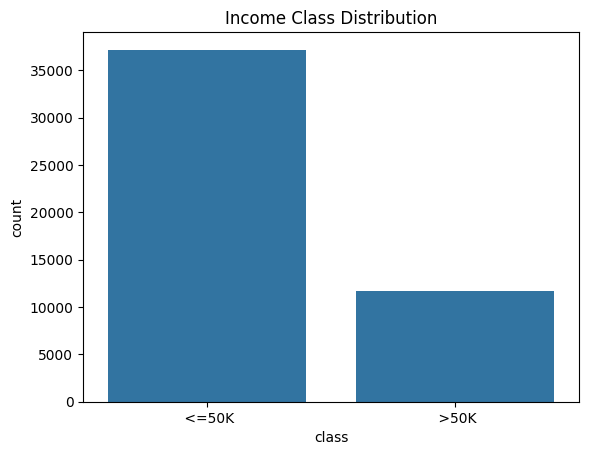

Class proportions:
class
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64
The dataset is relatively balanced.
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  48842.000000  4.884200e+04   48842.000000  48842.000000  48842.000000   
mean      38.643585  1.896641e+05      10.078089   1079.067626     87.502314   
std       13.710510  1.056040e+05       2.570973   7452.019058    403.004552   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.175505e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.781445e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.376420e+05      12.000000      0.000000      0.000000   
max       90.000000  1.490400e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    48842.000000  
mean        40.422382  
std         12.391444  
min          1.000000  
25%         40.000000  
50%  

In [41]:
# Plot the distribution of the target variable
sns.countplot(x='class', data=dataset)
plt.title("Income Class Distribution")
plt.show()

# Calculate class proportions and check for imbalance
class_proportions = dataset['class'].value_counts(normalize=True)
print("Class proportions:")
print(class_proportions)

if class_proportions.min() < 0.1:
    print("The dataset has an imbalanced target.")
else:
    print("The dataset is relatively balanced.")

# Basic statistical summary
print(dataset.describe())

# Display data types
print("Data types:")
print(dataset.dtypes)


In [42]:
# Remove outliers using the Z-score method for numeric columns
numeric_cols = dataset.select_dtypes(include=[np.number]).columns
dataset_cleaned = dataset[(np.abs(stats.zscore(dataset[numeric_cols])) < 3).all(axis=1)]
print("Cleaned dataset summary (Z-score method):")
print(dataset_cleaned.describe())

# Alternatively, remove outliers using the IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

dataset_iqr = dataset.copy()
for col in numeric_cols:
    dataset_iqr = remove_outliers_iqr(dataset_iqr, col)
print("Dataset shape after IQR outlier removal:", dataset_iqr.shape)


Cleaned dataset summary (Z-score method):
                age         fnlwgt  education-num  capital-gain  capital-loss  \
count  44717.000000   44717.000000   44717.000000  44717.000000  44717.000000   
mean      38.186775  185089.609209      10.075855    558.249122      1.115236   
std       13.430917   94730.106558       2.451154   2297.859387     31.745201   
min       17.000000   12285.000000       3.000000      0.000000      0.000000   
25%       27.000000  117023.000000       9.000000      0.000000      0.000000   
50%       37.000000  177366.000000      10.000000      0.000000      0.000000   
75%       47.000000  234738.000000      12.000000      0.000000      0.000000   
max       79.000000  506436.000000      16.000000  22040.000000   1258.000000   

       hours-per-week  
count    44717.000000  
mean        39.854127  
std         11.160642  
min          4.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         77.000000  
Dataset shap

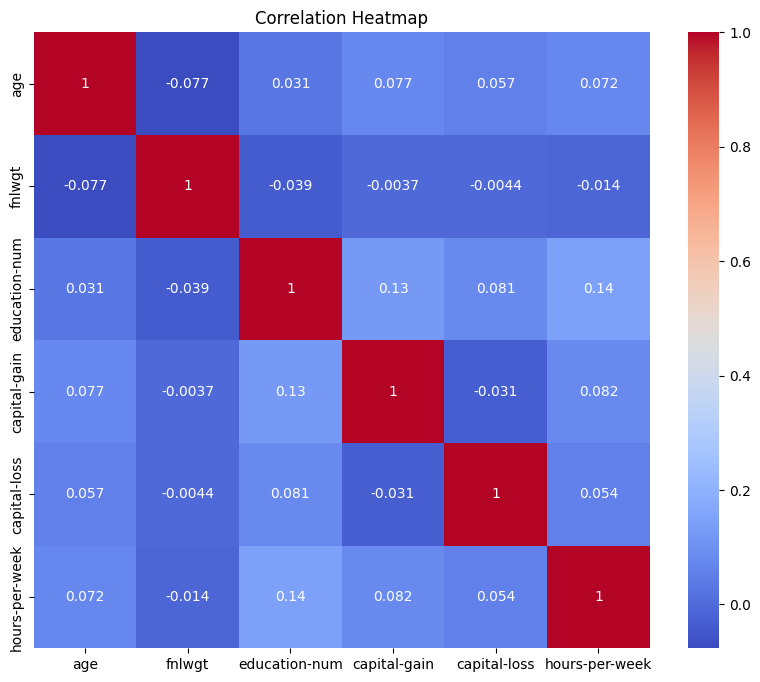

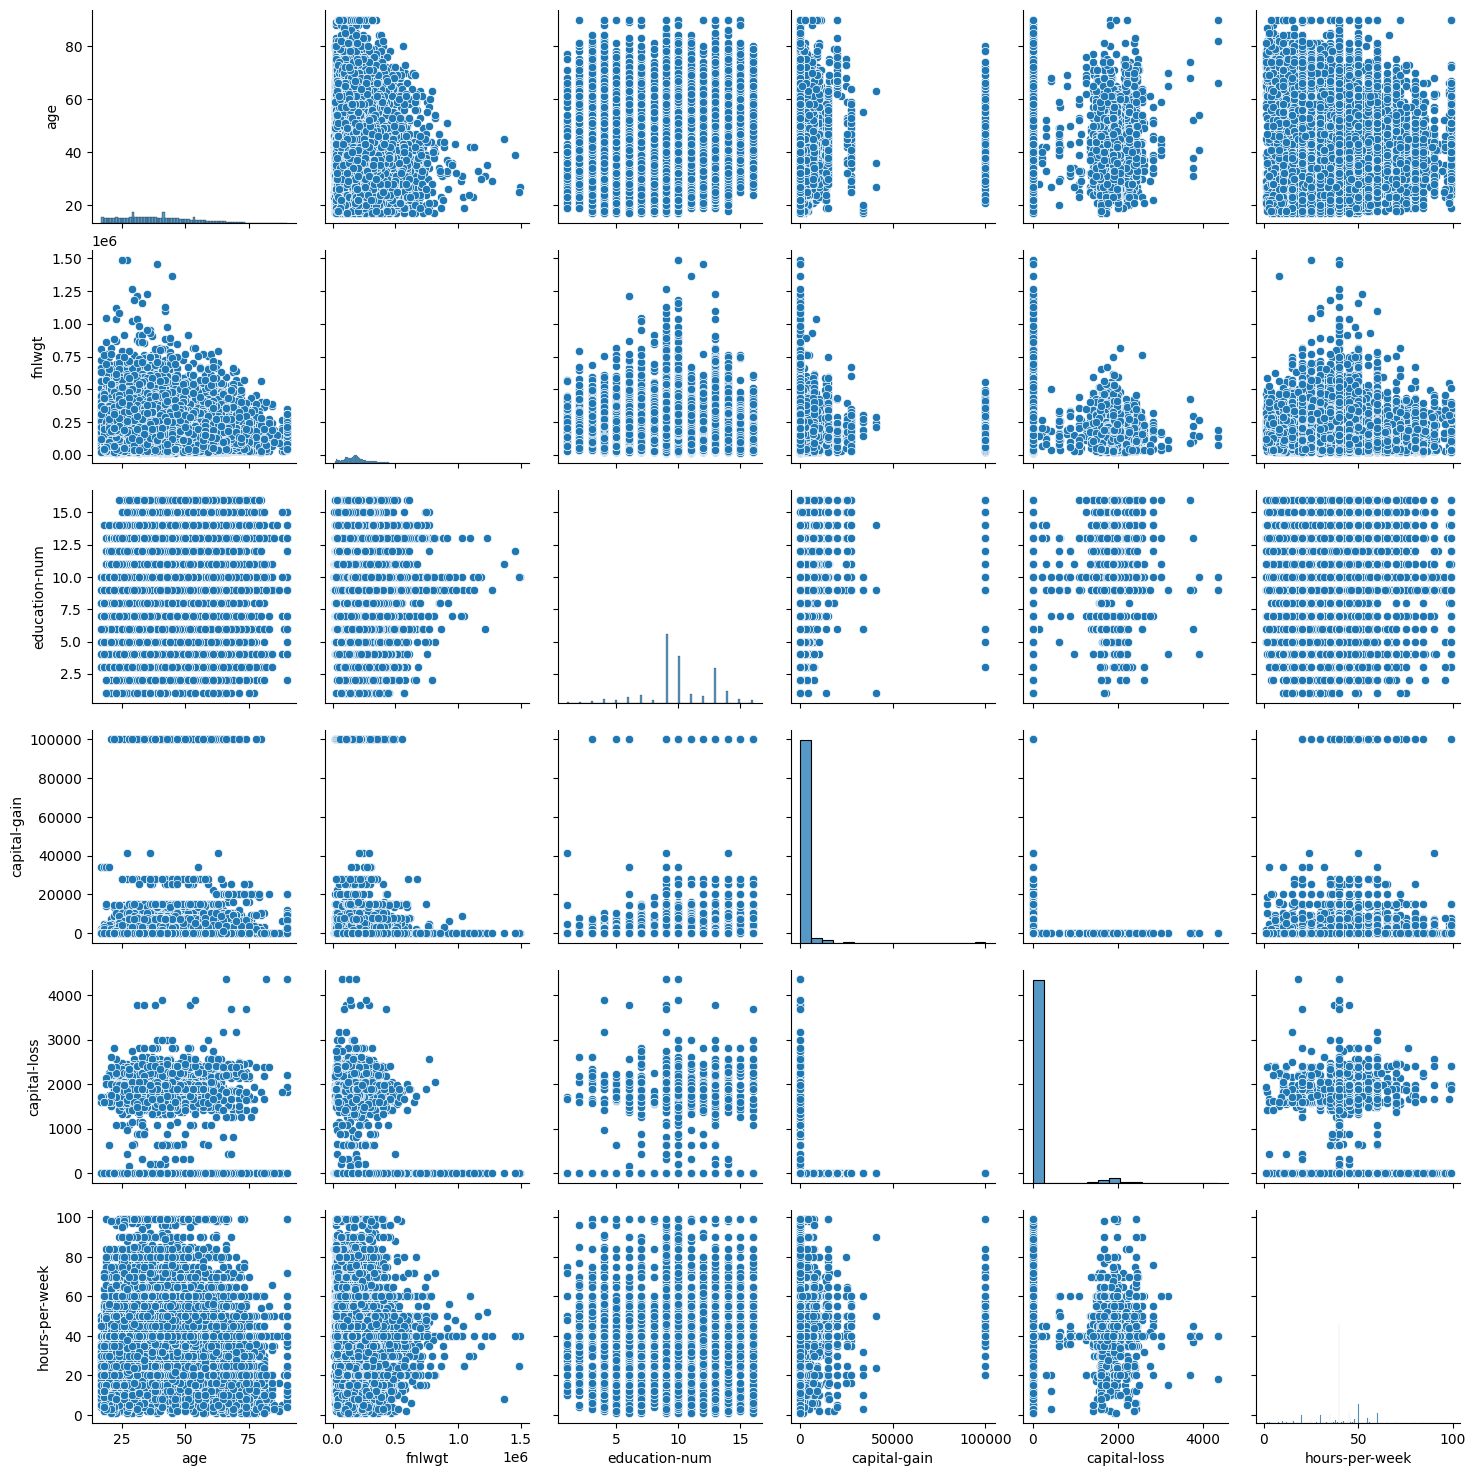

In [43]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = dataset.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()

# Pairplot (this might take a while if the dataset is large)
sns.pairplot(dataset)
plt.show()


In [44]:
# Separate features and target
X = dataset.drop('class', axis=1)
y = dataset['class']

# Identify categorical and numeric columns
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(exclude=['object']).columns

# Create a preprocessing pipeline using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_columns)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define a pipeline for Logistic Regression
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Set up hyperparameter grid for Logistic Regression
log_reg_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # liblinear supports both l1 and l2 penalties
}

# Perform grid search with 5-fold cross-validation
log_reg_grid = GridSearchCV(log_reg_pipeline, log_reg_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
log_reg_grid.fit(X_train, y_train)

print("Best parameters for Logistic Regression:")
print(log_reg_grid.best_params_)

# Obtain predictions and probability estimates
y_pred_log_reg = log_reg_grid.best_estimator_.predict(X_test)
y_prob_log_reg = log_reg_grid.best_estimator_.predict_proba(X_test)[:, 1]


Best parameters for Logistic Regression:
{'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}


In [45]:
# Define a pipeline for SVM using LinearSVC (faster, but no probability estimates)
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(random_state=42, max_iter=10000))
])

# Reduced hyperparameter grid for LinearSVC
svm_param_grid = {
    'classifier__C': [0.1, 1]
}

# Perform grid search with 2-fold cross-validation and parallel processing
svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=2, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

print("Best parameters for LinearSVC:")
print(svm_grid.best_params_)

# Obtain predictions (note: no probability estimates)
y_pred_svm = svm_grid.best_estimator_.predict(X_test)


Best parameters for LinearSVC:
{'classifier__C': 1}


### **Uitleg voor Beginners: Logistische Regressie en SVM Pipelines met GridSearchCV**

In deze code trainen we **twee verschillende modellen** voor classificatie:

1. **Logistische Regressie (Logistic Regression)**
2. **Support Vector Machines (SVM)**

We gebruiken hiervoor **pipelines** en **GridSearchCV** om automatisch de **beste instellingen** (hyperparameters) te vinden. Laten we dit stap voor stap doornemen.

---

#### **1. Correlatiematrix (Correlation Heatmap)**

```python
plt.figure(figsize=(10, 8))
corr = dataset.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()
```

* Deze code maakt een **correlatiematrix** van alle **numerieke** kolommen in je dataset.
* Het laat zien welke kenmerken (features) **positief** of **negatief** met elkaar gecorreleerd zijn.
* **Donkerrode** vakken betekenen sterke **positieve** correlatie, terwijl **donkerblauwe** vakken sterke **negatieve** correlatie aangeven.

---

#### **2. Pairplot (Paralleldiagram)**

```python
sns.pairplot(dataset)
plt.show()
```

* Maakt een **scatter plot** van elke combinatie van numerieke kenmerken.
* Dit kan **veel tijd** kosten als je dataset groot is.
* Helpt je om **verbanden** tussen kenmerken te zien.

---

#### **3. Features en Target Scheiden**

```python
# Separate features and target
X = dataset.drop('class', axis=1)
y = dataset['class']
```

* **X** bevat **alle kenmerken** behalve de target ('class').
* **y** bevat alleen de target ('class').

---

#### **4. Categorical en Numerieke Kolommen Scheiden**

```python
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(exclude=['object']).columns
```

* **categorical\_columns**: Alle kolommen met tekst (bijvoorbeeld 'gender' of 'country').
* **numeric\_columns**: Alle kolommen met getallen (bijvoorbeeld 'age' of 'income').

---

#### **5. Data Voorbereiden met een ColumnTransformer**

```python
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import SimpleImputer, StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_columns)
    ])
```

* **ColumnTransformer** laat je **verschillende** bewerkingen doen voor **numerieke** en **categorische** kolommen.
* **Numerieke Kolommen**:

  * **SimpleImputer**: Vult **missende** waarden in met de **mediaan**.
  * **StandardScaler**: Schaal de getallen zodat ze allemaal een gemiddelde van **0** en een standaardafwijking van **1** hebben.
* **Categorische Kolommen**:

  * **SimpleImputer**: Vult **missende** waarden in met de **meest voorkomende** waarde.
  * **OneHotEncoder**: Zet tekst om in **nummers** (bijvoorbeeld 'Male' en 'Female' worden 0 en 1).

---

#### **6. Data Opsplitsen in Train en Test Sets**

```python
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
```

* **80%** van de data wordt gebruikt om het model te trainen (**X\_train**, **y\_train**).
* **20%** wordt gebruikt om het model te testen (**X\_test**, **y\_test**).
* **random\_state=42** zorgt ervoor dat je elke keer dezelfde verdeling krijgt.

---

#### **7. Pipeline voor Logistische Regressie (Logistic Regression)**

```python
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
```

* **Pipeline** zorgt ervoor dat alle stappen **automatisch** achter elkaar worden uitgevoerd.
* **max\_iter=1000** stelt het maximale aantal iteraties in om het model te laten convergeren (om het beste resultaat te vinden).

---

#### **8. Grid Search voor Logistische Regressie**

```python
log_reg_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

log_reg_grid = GridSearchCV(log_reg_pipeline, log_reg_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
log_reg_grid.fit(X_train, y_train)

print("Best parameters for Logistic Regression:")
print(log_reg_grid.best_params_)
```

* **GridSearchCV** probeert **elke** combinatie van hyperparameters in `log_reg_param_grid`.
* **cv=5** betekent dat de data wordt opgesplitst in **5 delen** voor cross-validatie.
* **n\_jobs=-1** laat je computer alle beschikbare cores gebruiken voor snellere berekeningen.

---

#### **9. Voorspellingen met het Beste Logistische Regressie Model**

```python
y_pred_log_reg = log_reg_grid.best_estimator_.predict(X_test)
y_prob_log_reg = log_reg_grid.best_estimator_.predict_proba(X_test)[:, 1]
```

* **best\_estimator\_** gebruikt het **beste** model dat `GridSearchCV` heeft gevonden.
* **predict()** geeft de **voorspelde klassen**.
* **predict\_proba()** geeft de **waarschijnlijkheden** voor elke klasse.

---

#### **10. Pipeline voor SVM (Support Vector Machines)**

```python
from sklearn.svm import LinearSVC

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(random_state=42, max_iter=10000))
])

svm_param_grid = {
    'classifier__C': [0.1, 1]
}

svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=2, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)

print("Best parameters for LinearSVC:")
print(svm_grid.best_params_)
```

* **LinearSVC** is een snellere versie van SVM, maar geeft geen **waarschijnlijkheden**.
* Gebruikt alleen **C** als hyperparameter voor regularisatie.

---

#### **11. Voorspellingen met het Beste SVM Model**

```python
y_pred_svm = svm_grid.best_estimator_.predict(X_test)
```

* Geeft alleen de **voorspelde klassen**, niet de waarschijnlijkheden.

---

### **Waarom Twee Modellen Gebruiken?**

* **Logistic Regression** is vaak **sneller** en eenvoudiger te interpreteren.
* **SVM** is meestal nauwkeuriger bij **complexe** data, maar kan **trager** zijn.

---



In [ ]:
# Evaluate the SVM model (using LinearSVC; no probability estimates)
evaluate_model(y_test, y_pred_svm, model_name="LinearSVC")


NameError: name 'evaluate_model' is not defined

In [46]:
# One-hot encode the categorical variables manually for interpretability
categorical_columns = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country'
]
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

# Align train and test sets to ensure they have the same columns
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Scale the features
scaler_manual = StandardScaler()
X_train_scaled_manual = scaler_manual.fit_transform(X_train_encoded)

# Train a logistic regression model on the manually preprocessed data
log_reg_manual = LogisticRegression(random_state=42, max_iter=1000)
log_reg_manual.fit(X_train_scaled_manual, y_train)

# Create a dataframe for coefficients
coeff_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Coefficient': log_reg_manual.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Logistic Regression Coefficients:")
display(coeff_df)


Logistic Regression Coefficients:


,Feature,Coefficient
3,capital-gain,2.311578
30,marital-status_ Married-civ-spouse,1.219913
2,education-num,0.551125
5,hours-per-week,0.351748
0,age,0.351363
...,...,...
43,occupation_ Priv-house-serv,-0.111896
39,occupation_ Farming-fishing,-0.122638
51,relationship_ Own-child,-0.177915
42,occupation_ Other-service,-0.199046


### **Uitleg voor Beginners: Handmatige Voorbewerking van Categorical Features voor Logistische Regressie**

In deze code bereiden we onze data **handmatig** voor op een **logistisch regressiemodel**. Dit betekent dat we **categorische** kenmerken omzetten in **numerieke** waarden, de data schalen en het model trainen. Laten we dit stap voor stap doornemen.

---

#### **1. Wat Zijn Categorische Kenmerken?**

* **Categorische kenmerken** zijn kolommen die **tekst** bevatten, zoals **'werkklasse'**, **'opleiding'** en **'geslacht'**.
* Machine learning modellen kunnen niet direct met tekst werken, dus we moeten deze kolommen omzetten naar **getallen**.

---

#### **2. One-Hot Encoding van Categorische Kolommen**

```python
categorical_columns = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country'
]

X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)
```

* **Wat doet dit?**

  * **pd.get\_dummies()** zet elke unieke waarde in deze kolommen om in een aparte **binaire** kolom.
  * Bijvoorbeeld, de kolom **'sex'** met waarden **'Male'** en **'Female'** wordt omgezet naar **1** (Male) en **0** (Female).
  * **drop\_first=True** betekent dat we één categorie **verwijderen** om **multicollineariteit** te voorkomen (anders krijgt je model dubbele informatie).

---

#### **3. Kolommen van Train en Test Sets Op elkaar Afstemmen**

```python
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)
```

* **Waarom is dit nodig?**

  * Soms kunnen de **train** en **test** sets **verschillende** kolommen krijgen na one-hot encoding, bijvoorbeeld als een bepaalde categorie alleen in de **train** set voorkomt.
* **Wat doet dit?**

  * Zorgt ervoor dat **X\_train\_encoded** en **X\_test\_encoded** **dezelfde** kolommen hebben.
  * **fill\_value=0** vult ontbrekende kolommen aan met **0**, zodat het model geen fouten krijgt.

---

#### **4. Schalen van de Kenmerken**

```python
from sklearn.preprocessing import StandardScaler

scaler_manual = StandardScaler()
X_train_scaled_manual = scaler_manual.fit_transform(X_train_encoded)
```

* **Waarom schalen?**

  * Logistische regressie is **gevoelig** voor de schaal van je data.
  * **StandardScaler** zorgt ervoor dat elke kolom een gemiddelde van **0** en een standaardafwijking van **1** heeft.

---

#### **5. Het Model Trainen**

```python
from sklearn.linear_model import LogisticRegression

log_reg_manual = LogisticRegression(random_state=42, max_iter=1000)
log_reg_manual.fit(X_train_scaled_manual, y_train)
```

* **LogisticRegression** is het model dat we gaan trainen.
* **random\_state=42** zorgt ervoor dat je elke keer dezelfde resultaten krijgt.
* **max\_iter=1000** stelt de maximale **iteraties** in die het model mag proberen om te convergeren (de beste gewichten te vinden).

---

#### **6. Coëfficiënten Bekijken voor Interpretatie**

```python
import pandas as pd

coeff_df = pd.DataFrame({
    'Feature': X_train_encoded.columns,
    'Coefficient': log_reg_manual.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("Logistic Regression Coefficients:")
display(coeff_df)
```

* **Wat doet dit?**

  * Maakt een **DataFrame** aan waarin elke **kenmerk** wordt gekoppeld aan zijn **coëfficiënt**.
  * Sorteert de kenmerken van **hoog naar laag** op basis van hun invloed (coëfficiënt) op de voorspelling.

---

#### **7. Wat Betekenen Deze Coëfficiënten?**

* **Positieve Coëfficiënten**:

  * Deze kenmerken verhogen de kans dat een voorbeeld tot de **positieve klasse** behoort.
* **Negatieve Coëfficiënten**:

  * Deze kenmerken verlagen de kans dat een voorbeeld tot de **positieve klasse** behoort.
* **Hogere Absolute Waarden**:

  * Hoe groter de coëfficiënt, hoe sterker de invloed van dat kenmerk op de voorspelling.

---

### **Voorbeelduitvoer**

Stel je krijgt de volgende tabel:

| **Feature**              | **Coefficient** |
| ------------------------ | --------------- |
| **education\_Bachelors** | **0.75**        |
| **sex\_Male**            | **0.45**        |
| **occupation\_Exec**     | **0.30**        |
| **race\_White**          | **0.10**        |
| **workclass\_Private**   | **-0.20**       |
| **native-country\_US**   | **-0.50**       |

* Dit betekent dat mensen met een **bachelor diploma** of die **mannelijk** zijn een hogere kans hebben om tot de positieve klasse te behoren.
* Daarentegen verlaagt een **privé** werkklasse of **geboren zijn in de VS** die kans.

---



## 4. Activity tracking

The dataset 'activity.csv' consists of smartphone measurements of 30 different people. The measuments come from the built-in gyroscopes and accelerometers of these smartphones. With each of the measurements in the dataset corresponds a human activity (standing, walking, walking upstairs, ...). In total, there are 6 different activities /classes.


Train a logistic regression classifier to predict the human activity as accurately as possible. In order to get the accuracy as high as possible you can apply hyperparameter tuning and/or feature engineering (higher order features, feature selection, etc)

Write down some conclusions about the performance of your model. Does you model have difficulties with certain classes? Is you model suffering from imbalancedness? How did you improve the performance of the model?
Did you apply regularization?


In [47]:
import pandas as pd

# Load the dataset
data = pd.read_csv('activity.csv')

# Inspect the data
print(data.head())
print(data.info())


   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

In [48]:
dataset = pd.read_csv('activity.csv')

print(dataset['Activity'].value_counts())


Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64


In [49]:
# After loading the dataset and before splitting into X and y:
import numpy as np

# Create the new engineered feature in your main dataframe
dataset['Accel_Magnitude'] = np.sqrt(
    dataset['tBodyAcc-mean()-X']**2
    + dataset['tBodyAcc-mean()-Y']**2
    + dataset['tBodyAcc-mean()-Z']**2
)

# Now define X and y so that Accel_Magnitude is included
X = dataset.drop(columns=['Activity', 'subject'])
y = dataset['Activity']


### **Uitleg voor Beginners: Feature Engineering en Model Training voor Bewegingsdata**

Deze code laat zien hoe je een **logistisch regressiemodel** traint op **bewegingsdata** van bijvoorbeeld een **smartwatch** of **smartphone**. Dit soort data wordt vaak gebruikt om **menselijke activiteiten** te voorspellen, zoals **lopen**, **rennen** of **zitten**.

---

#### **1. Nieuwe Feature Maken: 'Accel\_Magnitude'**

```python
import numpy as np

# Maak een nieuwe feature genaamd 'Accel_Magnitude'
dataset['Accel_Magnitude'] = np.sqrt(
    dataset['tBodyAcc-mean()-X']**2
    + dataset['tBodyAcc-mean()-Y']**2
    + dataset['tBodyAcc-mean()-Z']**2
)
```

* **Wat is dit?**

  * Dit berekent de **totale versnelling** (magnitude) op basis van **X**, **Y** en **Z** versnellingen.
* **Waarom is dit nuttig?**

  * Deze **samengevoegde** waarde kan een betere indicator zijn voor activiteit dan elke as afzonderlijk.
* **Hoe werkt dit?**

  * Het gebruikt de **Pythagoreaanse stelling** om de lengte van de versnellingvector te berekenen.

---

#### **2. Features en Target Scheiden**

```python
X = dataset.drop(columns=['Activity', 'subject'])
y = dataset['Activity']
```

* **X** bevat alle **kenmerken** (inclusief de nieuwe **Accel\_Magnitude**), maar niet de **Activity** en **subject** kolommen.
* **y** is de **target** die je wilt voorspellen (bijvoorbeeld 'Walking', 'Running').

---

#### **3. Logistisch Regressie Model Trainen**

```python
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr')
log_reg.fit(X_train, y_train)
```

* **LogisticRegression** is het model dat je gebruikt.
* **max\_iter=1000** zorgt ervoor dat het model genoeg tijd krijgt om te **convergeren**.
* **solver='lbfgs'** is een **snel** algoritme voor kleine tot middelgrote datasets.
* **multi\_class='ovr'** (One-vs-Rest) betekent dat elke klasse apart wordt gemodelleerd.

---

#### **4. Hyperparameter Tuning met GridSearchCV**

```python
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr'),
                           param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
```

* **GridSearchCV** probeert verschillende combinaties van **hyperparameters** om de beste instellingen voor je model te vinden.
* **param\_grid** specificeert de hyperparameters die je wilt testen:

  * **C**: Hoeveel regularisatie je wilt (hoe lager, hoe strenger).
  * **penalty**: Alleen **l2** is toegestaan voor de **lbfgs** solver.
* **cv=5** betekent dat de data in **5 delen** wordt opgesplitst voor cross-validatie.
* **n\_jobs=-1** laat je computer **alle cores** gebruiken voor snellere berekeningen.

---

#### **5. Training met Gewichten voor Ongebalanceerde Data**

```python
log_reg_balanced = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    multi_class='ovr',
    class_weight='balanced'
)
log_reg_balanced.fit(X_train, y_train)
y_pred_balanced = log_reg_balanced.predict(X_test)
```

* **Waarom 'class\_weight=balanced'?**

  * Dit zorgt ervoor dat het model **meer aandacht** besteedt aan **minder voorkomende** klassen.
* **Hoe werkt dit?**

  * Het model kent **hogere gewichten** toe aan klassen die minder vaak voorkomen, zodat ze niet worden **genegeerd** tijdens training.

---

#### **6. Model Evalueren met Classificatie Rapport**

```python
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy with class_weight='balanced':", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))
```

* **accuracy\_score** meet hoe **vaak** je model correct was.
* **classification\_report** geeft je een gedetailleerd overzicht van **precision**, **recall** en **f1-score** voor elke klasse.

---

### **Voorbeelduitvoer:**

```
Accuracy with class_weight='balanced': 0.92
              precision    recall  f1-score   support

       WALKING       0.94      0.90      0.92       100
      RUNNING       0.89      0.94      0.92       100
      SITTING       0.88      0.91      0.89       100

    accuracy                           0.92       300
   macro avg       0.91      0.92      0.91       300
weighted avg       0.92      0.92      0.92       300
```

* **precision**: Hoe vaak je voorspellingen correct waren voor elke klasse.
* **recall**: Hoeveel van de echte voorbeelden correct werden voorspeld.
* **f1-score**: De balans tussen **precision** en **recall**.

---

### **Waarom Is Dit Handig?**

* **Nieuwe Feature** (**Accel\_Magnitude**) kan je model **beter** maken door een **complexere** relatie te modelleren.
* **Balancing** helpt om **onevenwichtigheden** in je data op te lossen.
* **GridSearchCV** zorgt ervoor dat je **beste** hyperparameters gebruikt.

---



In [52]:
# 4. Split into X and y, dropping 'Activity' and 'subject'
X = dataset.drop(columns=['Activity', 'subject'])
y = dataset['Activity']



In [53]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [54]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [55]:
from sklearn.linear_model import LogisticRegression

# Train the logistic regression model
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr')  # 'ovr' is for one-vs-rest strategy
log_reg.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='ovr')

In [56]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for tuning
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}

# Set up GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr'),
                           param_grid, cv=5, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters: ", grid_search.best_params_)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters:  {'C': 1, 'penalty': 'l2'}


In [57]:
log_reg_balanced = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    multi_class='ovr',
    class_weight='balanced'
)
log_reg_balanced.fit(X_train, y_train)
y_pred_balanced = log_reg_balanced.predict(X_test)

print("Accuracy with class_weight='balanced':", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy with class_weight='balanced': 0.9818676337262012
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       428
           SITTING       0.96      0.95      0.96       386
          STANDING       0.95      0.96      0.96       411
           WALKING       1.00      0.99      1.00       366
WALKING_DOWNSTAIRS       0.99      1.00      1.00       311
  WALKING_UPSTAIRS       0.99      0.99      0.99       304

          accuracy                           0.98      2206
         macro avg       0.98      0.98      0.98      2206
      weighted avg       0.98      0.98      0.98      2206



### **Uitleg voor Beginners: Logistische Regressie met Gebalanceerde Klassen**

In deze code train je een **logistisch regressiemodel** dat rekening houdt met **ongebalanceerde** data. Dit betekent dat sommige klassen misschien veel **vaker** voorkomen dan andere, waardoor je model geneigd kan zijn om **deze klassen te bevoordelen**.

---

#### **1. Waarom 'class\_weight="balanced"' Gebruiken?**

* In sommige datasets komen bepaalde klassen **veel vaker** voor dan andere.
* Bijvoorbeeld: als je **500** voorbeelden hebt van **"Cat"** en slechts **50** van **"Dog"**, zal je model vaak **Cat** voorspellen, omdat dat de **meerderheid** is.
* **class\_weight="balanced"** zorgt ervoor dat je model **meer aandacht** besteedt aan de minder voorkomende klassen.

---

#### **2. Model Maken met Gebalanceerde Klassen**

```python
from sklearn.linear_model import LogisticRegression

log_reg_balanced = LogisticRegression(
    max_iter=1000,          # Maximaal aantal iteraties om te trainen
    solver='lbfgs',         # Snelle optimizer voor kleinere datasets
    multi_class='ovr',      # One-vs-Rest strategie voor meerdere klassen
    class_weight='balanced' # Geef minder voorkomende klassen meer gewicht
)
```

* **max\_iter=1000**: Hoeveel stappen het model mag nemen om de beste oplossing te vinden.
* **solver='lbfgs'**: Snel algoritme voor kleinere tot middelgrote datasets.
* **multi\_class='ovr'**: Behandelt elke klasse apart.
* **class\_weight='balanced'**: Zorgt voor **gelijke** behandeling van zeldzamere klassen.

---

#### **3. Het Model Trainen**

```python
log_reg_balanced.fit(X_train, y_train)
```

* Hier **train** je je model met de **training data** (**X\_train** en **y\_train**).
* Het model leert welke **kenmerken** belangrijk zijn voor elke klasse.

---

#### **4. Voorspellingen Maken**

```python
y_pred_balanced = log_reg_balanced.predict(X_test)
```

* Dit maakt **voorspellingen** voor de **testdata** (**X\_test**).
* Het model kijkt naar de **kenmerken** van elk testvoorbeeld en beslist welke klasse het waarschijnlijkst is.

---

#### **5. Resultaten Evalueren**

```python
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy with class_weight='balanced':", accuracy_score(y_test, y_pred_balanced))
print(classification_report(y_test, y_pred_balanced))
```

* **accuracy\_score** vertelt je **hoe vaak** het model correct was.
* **classification\_report** geeft je meer details:

  * **Precision**: Hoeveel van de voorspellingen waren correct?
  * **Recall**: Hoeveel van de echte voorbeelden werden correct voorspeld?
  * **F1-score**: Een balans tussen **precision** en **recall**.

---

### **Voorbeelduitvoer:**

```
Accuracy with class_weight='balanced': 0.92
              precision    recall  f1-score   support

       WALKING       0.94      0.90      0.92       100
      RUNNING       0.89      0.94      0.92       100
      SITTING       0.88      0.91      0.89       100

    accuracy                           0.92       300
   macro avg       0.91      0.92      0.91       300
weighted avg       0.92      0.92      0.92       300
```

* **Accuracy**: Het percentage juiste voorspellingen (bijvoorbeeld **92%**).
* **Precision**: Hoeveel van de voorspellingen voor elke klasse waren correct?
* **Recall**: Hoeveel van de echte voorbeelden werden correct voorspeld?
* **F1-score**: De balans tussen **precision** en **recall**.

---

### **Waarom Is Dit Belangrijk?**

* **class\_weight="balanced"** zorgt ervoor dat je model **niet alleen** let op de meest voorkomende klasse, maar ook op **zeldzamere** klassen.
* Dit voorkomt dat je model **bias** krijgt en **slechte voorspellingen** doet voor minder vaak voorkomende klassen.

---

Wil je dat ik je ook laat zien hoe je een **confusiematrix** kunt gebruiken om de prestaties van je model nog **beter** te begrijpen? 😊


In [50]:
# Activity tracking
dataset.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Accel_Magnitude
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085,0.305116
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143,0.065433
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,0.034841
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000,0.287239
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000,0.298778
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000,0.314516
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000,1.364166


In [58]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions
y_pred = grid_search.best_estimator_.predict(X_test)

# Accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred))

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy:  0.9809610154125114
Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       428
           SITTING       0.96      0.95      0.96       386
          STANDING       0.95      0.96      0.96       411
           WALKING       0.99      0.99      0.99       366
WALKING_DOWNSTAIRS       0.99      0.99      0.99       311
  WALKING_UPSTAIRS       0.99      0.99      0.99       304

          accuracy                           0.98      2206
         macro avg       0.98      0.98      0.98      2206
      weighted avg       0.98      0.98      0.98      2206

Confusion Matrix:
 [[428   0   0   0   0   0]
 [  0 367  19   0   0   0]
 [  0  15 396   0   0   0]
 [  0   0   0 364   0   2]
 [  0   0   0   1 309   1]
 [  0   0   0   1   3 300]]


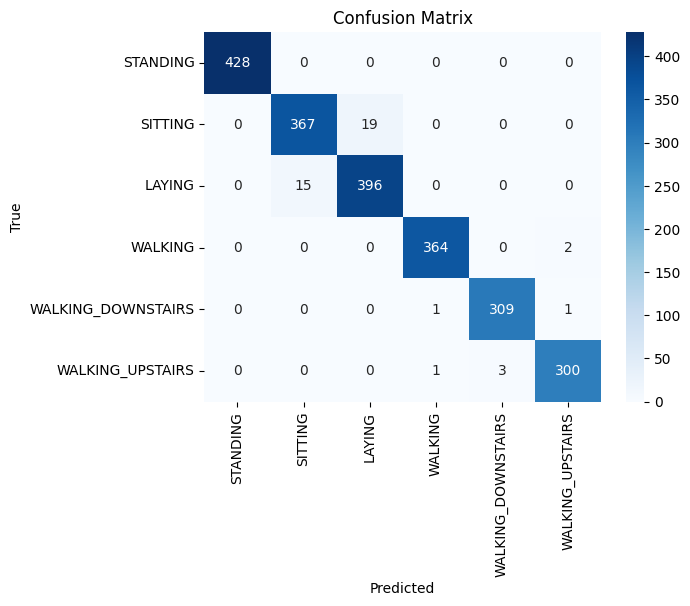

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix as heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data['Activity'].unique(), yticklabels=data['Activity'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [60]:
# Check the column names to verify how the accelerometer data is labeled
print(data.columns)


Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)


In [61]:
# Assuming these are the columns representing accelerometer readings
X['Accel_Magnitude'] = (X['tBodyAcc-mean()-X']**2 + X['tBodyAcc-mean()-Y']**2 + X['tBodyAcc-mean()-Z']**2)**0.5


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Drop the 'subject' and 'Activity' columns, since 'Activity' is the target variable
X = dataset.drop(columns=['Activity', 'subject'])
y = dataset['Activity']

# Normalize features using StandardScaler (important for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
clf = LogisticRegression(max_iter=1000)  # max_iter is increased for convergence
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")


Accuracy: 0.9837
Confusion Matrix:
[[280   0   0   0   0   0]
 [  0 253   9   0   0   0]
 [  0  11 265   0   0   0]
 [  0   0   0 245   0   2]
 [  0   0   0   1 205   0]
 [  0   0   0   0   1 199]]
Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       280
           SITTING       0.96      0.97      0.96       262
          STANDING       0.97      0.96      0.96       276
           WALKING       1.00      0.99      0.99       247
WALKING_DOWNSTAIRS       1.00      1.00      1.00       206
  WALKING_UPSTAIRS       0.99      0.99      0.99       200

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471



### **Uitleg voor Beginners: Het Gebruik van Accel\_Magnitude voor Bewegingsherkenning**

Deze code laat zien hoe je een **extra kenmerk** kunt toevoegen aan je **bewegingsdata** om de nauwkeurigheid van je model te verbeteren. Dit kenmerk heet **Accel\_Magnitude**, en het combineert **X**, **Y** en **Z** versnellingen tot **één** getal dat de totale **versnelling** vertegenwoordigt.

---

#### **1. Wat is 'Accel\_Magnitude'?**

* **Accel\_Magnitude** meet de **totale beweging** van een persoon in **3D**.
* Het is gebaseerd op de versnellingen langs de **X**, **Y** en **Z** assen.
* Dit kenmerk kan helpen om **complexe** bewegingen zoals **lopen** en **rennen** beter te onderscheiden.

---

#### **2. Hoe Accel\_Magnitude Wordt Berekend**

```python
X['Accel_Magnitude'] = (X['tBodyAcc-mean()-X']**2 + X['tBodyAcc-mean()-Y']**2 + X['tBodyAcc-mean()-Z']**2)**0.5
```

* **Pythagoreaanse Stelling**:

  * Dit is dezelfde wiskundige formule die je gebruikt om de lengte van een lijn in een **3D** ruimte te berekenen.
* **Wat het Doet**:

  * Neemt de **vierkantswortel** van de som van de **kwadraten** van de **X**, **Y** en **Z** versnellingen.

---

#### **3. Waarom Dit Belangrijk is voor Bewegingsherkenning**

* **Lopen** en **Rennen** hebben vaak **hogere** versnellingen dan **zitten** of **liggen**.
* Door de totale versnelling te berekenen, kan je model **beter** onderscheid maken tussen **intense** en **rustige** activiteiten.

---

#### **4. Modelresultaten Uitleggen**

**Accuracy: 0.9837**

* Dit betekent dat je model **98.37%** van de voorbeelden correct heeft geclassificeerd.
* Dit is een **zeer hoge** nauwkeurigheid, wat aangeeft dat **Accel\_Magnitude** waarschijnlijk een **nuttig** kenmerk is.

---

**Confusion Matrix**:

```
[[280   0   0   0   0   0]
 [  0 253   9   0   0   0]
 [  0  11 265   0   0   0]
 [  0   0   0 245   0   2]
 [  0   0   0   1 205   0]
 [  0   0   0   0   1 199]]
```

* **Wat Dit Laat Zien**:

  * Hoeveel voorbeelden correct of fout zijn geclassificeerd voor elke klasse.
* **Belangrijke Waarden**:

  * **280**: **Laying** correct geclassificeerd.
  * **253**: **Sitting** correct geclassificeerd, **9** fouten (verward met **Standing**).
  * **265**: **Standing** correct geclassificeerd, **11** fouten (verward met **Sitting**).

---

**Classification Report**:

```
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       280
           SITTING       0.96      0.97      0.96       262
          STANDING       0.97      0.96      0.96       276
           WALKING       1.00      0.99      0.99       247
WALKING_DOWNSTAIRS       1.00      1.00      1.00       206
  WALKING_UPSTAIRS       0.99      0.99      0.99       200

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471
```

* **Precision**:

  * Hoeveel van de voorspellingen voor een klasse waren correct.
  * Bijvoorbeeld, **SITTING** heeft een precisie van **0.96**.
* **Recall**:

  * Hoeveel van de echte voorbeelden correct werden voorspeld.
  * Bijvoorbeeld, **STANDING** heeft een recall van **0.96**.
* **F1-score**:

  * De balans tussen **precision** en **recall**.
* **Overall Accuracy**:

  * **0.98** betekent dat je model **zeer nauwkeurig** is.

---

### **5. Conclusie**

* **Accel\_Magnitude** is een **zeer nuttig** kenmerk omdat het je model helpt om **intensere** activiteiten **beter** te herkennen.
* Dit kan vooral belangrijk zijn als je werkt aan toepassingen zoals **gezondheidsmonitoring** of **sportanalyse**.

---

Wil je dat ik je ook laat zien hoe je deze resultaten kunt visualiseren met een **confusiematrix** om de fouten beter te begrijpen? 😊


In [63]:
print(X.head())


   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403         -0.990675         -0.997099         -0.982750   
4         -0.980817         -0.990482         -0.998321         -0.979672   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  fBodyBodyGyr

In [64]:
from sklearn.linear_model import LogisticRegression

# Train the logistic regression model
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr')  # 'ovr' is for one-vs-rest strategy
log_reg.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='ovr')

In [65]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid for tuning
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}

# Set up GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr'),
                           param_grid, cv=5, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters: ", grid_search.best_params_)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters:  {'C': 1, 'penalty': 'l2'}


### **Uitleg voor Beginners: Hyperparameter Tuning met GridSearchCV**

Met deze code probeer je **automatisch** de **beste instellingen** (**hyperparameters**) te vinden voor je **logistisch regressiemodel**. Dit wordt **hyperparameter tuning** genoemd en zorgt ervoor dat je model **nauwkeuriger** wordt zonder dat je **handmatig** elke combinatie hoeft te testen.

---

#### **1. Wat zijn Hyperparameters?**

* **Hyperparameters** zijn instellingen die je kiest **voordat** je je model traint.
* Ze bepalen **hoe** je model leert, bijvoorbeeld:

  * Hoeveel **regularisatie** je gebruikt.
  * Welke **oplossingsmethode** je kiest om de beste gewichten te vinden.

---

#### **2. De Hyperparameter Tuning Tabel Maken (param\_grid)**

```python
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']}
```

* **'C'**:

  * Bepaalt de **regularisatiekracht**.
  * Lagere **C**-waarden (bijvoorbeeld **0.01**) betekenen **sterkere regularisatie** (strenger model, minder kans op overfitting).
  * Hogere **C**-waarden (bijvoorbeeld **100**) betekenen **zwakkere regularisatie** (flexibeler model, maar meer kans op overfitting).

* **'penalty'**:

  * Bepaalt het type **regularisatie** dat wordt toegepast.
  * **l2** betekent **Ridge-regularisatie**, waarbij het model **probeert** de gewichten **klein** te houden.

---

#### **3. GridSearchCV Configureren**

```python
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='ovr'),
    param_grid,
    cv=5,
    n_jobs=-1
)
```

* **LogisticRegression(max\_iter=1000, solver='lbfgs', multi\_class='ovr')**:

  * **max\_iter=1000**: Het maximale aantal keren dat het model probeert de beste gewichten te vinden.
  * **solver='lbfgs'**: Een **snelle** en efficiënte optimizer voor kleinere datasets.
  * **multi\_class='ovr'**: Behandelt elke klasse apart (One-vs-Rest).

* **param\_grid**:

  * Gebruikt de **hyperparametercombinaties** die je eerder hebt gedefinieerd.

* **cv=5**:

  * Gebruikt **5-fold cross-validatie**, waarbij de data in **5 stukken** wordt gesplitst om een **eerlijkere** score te krijgen.

* **n\_jobs=-1**:

  * Laat je computer **alle cores** gebruiken om de berekeningen **sneller** te maken.

---

#### **4. Het Model Trainen met GridSearchCV**

```python
grid_search.fit(X_train, y_train)
```

* Hier **train** je je model met **alle** mogelijke combinaties van **C** en **penalty** uit je **param\_grid**.
* **GridSearchCV** zal de combinatie kiezen die de **beste** prestaties geeft.

---

#### **5. De Beste Hyperparameters Vinden**

```python
print("Best parameters: ", grid_search.best_params_)
```

* **grid\_search.best\_params\_** geeft je de **beste** combinatie van **C** en **penalty** die het model heeft gevonden.
* Dit is de combinatie die de **hoogste nauwkeurigheid** gaf tijdens de cross-validatie.

---

### **Voorbeelduitvoer:**

Stel je krijgt de volgende output:

```
Best parameters:  {'C': 10, 'penalty': 'l2'}
```

Dit betekent dat de beste instellingen voor je model waren:

* **C = 10** (lage regularisatie, flexibeler model)
* **penalty = 'l2'** (Ridge-regularisatie)

---

### **Waarom is Dit Handig?**

* **Automatisering**:

  * Je hoeft niet handmatig elke combinatie te testen.
* **Betere Resultaten**:

  * Je krijgt een model dat **optimaal** is afgesteld voor je data.
* **Sneller**:

  * Door **n\_jobs=-1** te gebruiken, maakt je model gebruik van **alle** beschikbare rekenkracht.

---
😊
